In [1]:
import os
from pathlib import Path

path = Path(os.curdir).absolute()
if str(path).split("\\")[-1] == "notebooks":
    os.chdir(path.parent)

import tensorflow.compat.v1 as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
import wandb

from roadtracer.discoverlib import geom
from roadtracer.infer import roadtracer_infer, get_model

from utils.datasets import ImageDataset
from utils.utils import *
from models import load_config, model_from_config
from train import train
import parameters

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device == 'cpu':
        return torch.from_numpy(x).cpu()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True)
    

image_filenames = sorted(glob(parameters.ROOT_PATH + '/training/images/*.png'))

images = np.zeros((len(image_filenames), 400, 400, 3), dtype=np.float32)
masks = np.zeros((len(image_filenames), 400, 400), dtype=np.float32)

m = model_from_config(load_config("UNet")).to(DEVICE)
m.load_state_dict(torch.load("checkpoints/unet/epoch_40.pt")["model_state_dict"])
m.eval()

with torch.no_grad():
    for f in image_filenames:
        i = int(f[:-4].split('_')[-1])

        images[i] = np.array(Image.open(f), dtype=np.float32)[:, :, :3] / 255.0
        x = np_to_tensor(np.moveaxis(cv2.resize(images[i], dsize=(384, 384)),-1,0), DEVICE)
        mask_pred = np.moveaxis(m(x.unsqueeze(0)).detach().cpu().numpy(),1,-1)
        masks[i] = cv2.resize(mask_pred[0], dsize=(400,400))

        im = Image.fromarray(masks[i] * 255).convert('L')
        im.save(parameters.ROOT_PATH + f"/training/predictions/satimage_{i}.png")


In [10]:
BLOCKING_DIST = 30
MIN_PROB = 0.999

def get_starting_locations(mask):
    indices = np.stack(np.unravel_index(np.argsort(mask, axis=None)[::-1], mask.shape), axis=1)
    starting_map = np.zeros(mask.shape, dtype=bool)
    starting_indices = []
    for (i0, j0) in indices:
        if mask[i0,j0] < MIN_PROB:
            break

        in_range = False
        for i in range(max(0,i0-BLOCKING_DIST),min(mask.shape[0],i0+BLOCKING_DIST+1)):
            for j in range(max(0,j0-BLOCKING_DIST),min(mask.shape[0],j0+BLOCKING_DIST+1)):
                in_range |= starting_map[i,j]
                if in_range:
                    break
        
        if not in_range:
            starting_map[i0,j0] = True
            starting_indices.append(geom.Point(i0 - 200,j0 - 200))

    return starting_indices

In [11]:
m, session = get_model()



INFO:tensorflow:Restoring parameters from c:\Users\ArniB\ETH\CIL\CIL-2024\roadtracer\model\model


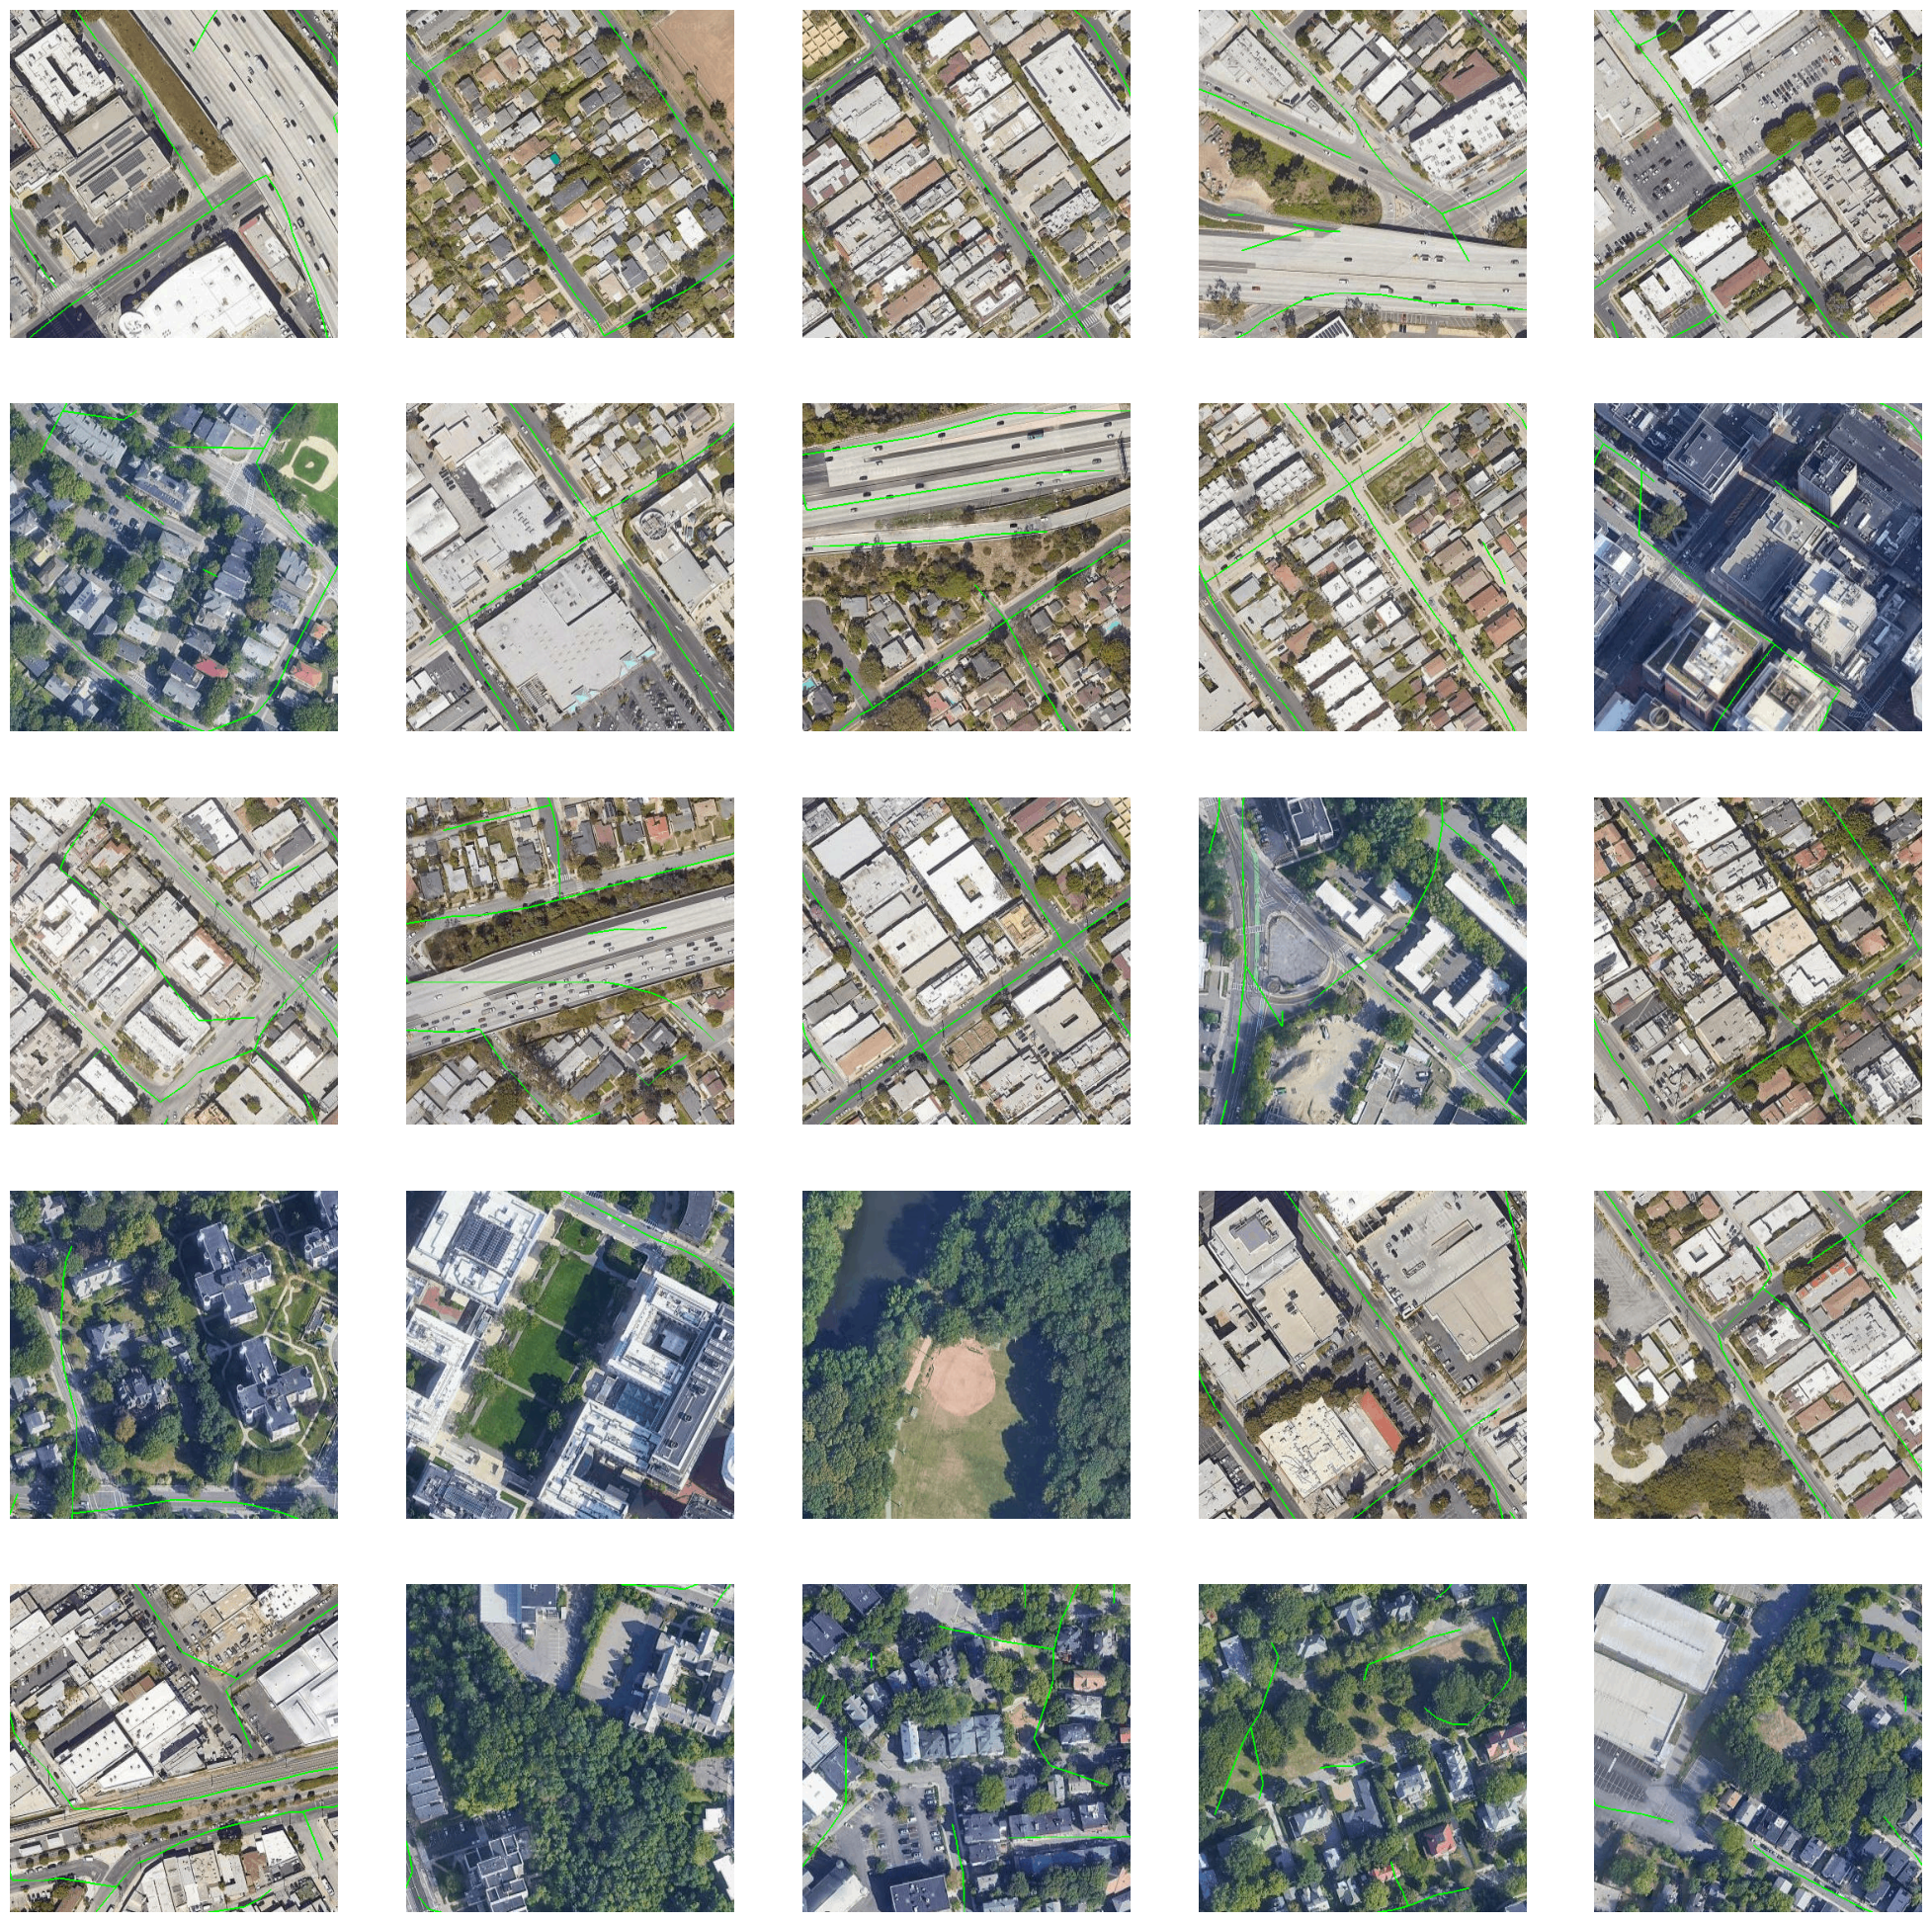

In [19]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))

for i in range(25):
    starting_indices = get_starting_locations(masks[i])

    roadtracer_img = roadtracer_infer(m, session, images[i], starting_indices)[:,:,None] * np.array([0.0, 1.0, 0.0])

    roadtracer_img += (np.sum(roadtracer_img, axis=-1) == 0)[:,:,None] * images[i]
    # roadtracer_img += (np.sum(roadtracer_img, axis=-1) == 0)[:,:,None] * masks[i,:,:,None] 
    # roadtracer_img += (np.sum(roadtracer_img, axis=-1) == 0)[:,:,None] * masks[i,:,:,None]  * images[i]
    
    axs[i//5, i%5].imshow(roadtracer_img)
    axs[i//5, i%5].set_axis_off()


In [7]:
roadtracer_imgs = np.zeros((len(images), 400, 400))

for i in tqdm(range(len(images))):
    starting_indices = get_starting_locations(masks[i])
    roadtracer_imgs[i] = roadtracer_infer(m, session, images[i], starting_indices)
    im = Image.fromarray(roadtracer_imgs[i] * 255).convert('L')
    im.save(params.ROOT_PATH + f"/training/roadtracer/satimage_{i}.png")

  0%|          | 0/144 [00:00<?, ?it/s]

In [3]:
epochs = 100

images = load_all_from_path(parameters.ROOT_PATH + '/training/images')[:, :, :, :3]
masks = load_all_from_path(parameters.ROOT_PATH + '/training/groundtruth')
graphs = load_all_from_path(parameters.ROOT_PATH + '/training/roadtracer')
images_with_graphs = np.concatenate([images, graphs[:,:,:,None]], axis=-1)

train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

train_images_with_graph, val_images_with_graph, train_masks_with_graph, val_masks_with_graph = train_test_split(
    images_with_graphs, masks, test_size=0.2, random_state=42
)

assert np.array_equal(train_masks, train_masks_with_graph) and np.array_equal(val_masks, val_masks_with_graph)

train_ds = ImageDataset(train_images, train_masks, device=DEVICE, use_patches=False, resize_to=(384, 384))
val_ds = ImageDataset(val_images, val_masks, device=DEVICE, use_patches=False, resize_to=(384, 384))

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=4, shuffle=True)

train_ds_with_graph = ImageDataset(train_images_with_graph, train_masks_with_graph, device=DEVICE, use_patches=False, resize_to=(384, 384))
val_ds_with_graph = ImageDataset(val_images_with_graph, val_masks_with_graph, device=DEVICE, use_patches=False, resize_to=(384, 384))

train_dl_with_graph = torch.utils.data.DataLoader(train_ds_with_graph, batch_size=4, shuffle=True)
val_dl_with_graph = torch.utils.data.DataLoader(val_ds_with_graph, batch_size=4, shuffle=True)

In [4]:
model_base = model_from_config(load_config("UNet")).to(DEVICE)
optimizer_base = torch.optim.Adam(model_base.parameters())
loss_fn = nn.BCELoss()

wandb.init(
    name="simple_unet",
    project="CIL-2024",
    config={
        "learning_rate": optimizer_base.param_groups[0]["lr"],
        "epochs": epochs,
        "n_training_examples": len(train_ds),
        "n_validation_examples": len(val_ds), 
        "parameter_count": sum([p.numel() for p in model_base.parameters() if p.requires_grad]),
    },
    group="UNet"
)


train(
    model=model_base,
    optimizer=optimizer_base,
    train_dl=train_dl,
    val_dl=val_dl,
    loss_fn=loss_fn,
    epoch_n=epochs,
    start_epoch=0,
    wandb = wandb,
    metric_fns= {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn, 'f1': f1_fn},
    config_name="UNet.yaml",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: abjarnsteins (abjarnsteins-eth-z-rich). Use `wandb login --relogin` to force relogin


Epoch 1/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.60it/s, val_loss=0.592]


	- loss = 0.4716110178108873
  	- val_loss = 0.5915698036551476
  	- acc = 0.1772591307245452
  	- val_acc = 0.1784301344305277
  	- patch_acc = 0.6252494469798845
  	- val_patch_acc = 0.27745226211845875
  	- f1 = 0.2750543386771761
  	- val_f1 = 0.2790485955774784
 


Epoch 2/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.87it/s, val_loss=0.437]


	- loss = 0.39494424133465206
  	- val_loss = 0.4373699687421322
  	- acc = 0.17725309292817937
  	- val_acc = 0.17945056408643723
  	- patch_acc = 0.7690922391825709
  	- val_patch_acc = 0.6958550326526165
  	- f1 = 0.27510984241962433
  	- val_f1 = 0.28063005208969116
 


Epoch 3/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.94it/s, val_loss=0.364]


	- loss = 0.37490165028078803
  	- val_loss = 0.36414122581481934
  	- acc = 0.17783923986656913
  	- val_acc = 0.17843204364180565
  	- patch_acc = 0.7843580410398286
  	- val_patch_acc = 0.7688802257180214
  	- f1 = 0.2759079722494915
  	- val_f1 = 0.27829534932971
 


Epoch 4/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.00it/s, val_loss=0.414]


	- loss = 0.369250422921674
  	- val_loss = 0.4141339585185051
  	- acc = 0.17751611615049429
  	- val_acc = 0.1750604845583439
  	- patch_acc = 0.7803570011566425
  	- val_patch_acc = 0.768229179084301
  	- f1 = 0.2754585563108839
  	- val_f1 = 0.27368556894361973
 


Epoch 5/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.02it/s, val_loss=0.393]


	- loss = 0.35441710465940934
  	- val_loss = 0.3928525745868683
  	- acc = 0.177208523298132
  	- val_acc = 0.18369886837899685
  	- patch_acc = 0.7990002406054529
  	- val_patch_acc = 0.7430013045668602
  	- f1 = 0.2749306318061105
  	- val_f1 = 0.2857987582683563
 


Epoch 6/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.20it/s, val_loss=0.486]


	- loss = 0.3524408196580821
  	- val_loss = 0.48583995550870895
  	- acc = 0.1771784743358349
  	- val_acc = 0.17450290080159903
  	- patch_acc = 0.7948146195247255
  	- val_patch_acc = 0.774305559694767
  	- f1 = 0.2749976957666463
  	- val_f1 = 0.27223892882466316
 


Epoch 7/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.38it/s, val_loss=0.35] 


	- loss = 0.3413618433064428
  	- val_loss = 0.35022624023258686
  	- acc = 0.17690605541755414
  	- val_acc = 0.17945056781172752
  	- patch_acc = 0.8031758892125097
  	- val_patch_acc = 0.8200412392616272
  	- f1 = 0.2746620265574291
  	- val_f1 = 0.28063004836440086
 


Epoch 8/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.41it/s, val_loss=0.399]


	- loss = 0.33439403412670926
  	- val_loss = 0.3985806368291378
  	- acc = 0.17700100073526645
  	- val_acc = 0.17988289892673492
  	- patch_acc = 0.8102051512948398
  	- val_patch_acc = 0.7789171114563942
  	- f1 = 0.27474807511115895
  	- val_f1 = 0.2795353401452303
 


Epoch 9/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.50it/s, val_loss=0.332]


	- loss = 0.32237167810571604
  	- val_loss = 0.33161113038659096
  	- acc = 0.1779437905241703
  	- val_acc = 0.1761940885335207
  	- patch_acc = 0.8184466896385982
  	- val_patch_acc = 0.8167860358953476
  	- f1 = 0.2760600606942999
  	- val_f1 = 0.2752271480858326
 


Epoch 10/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.26it/s, val_loss=0.418]


	- loss = 0.30679212613352413
  	- val_loss = 0.41784004122018814
  	- acc = 0.17749421015895647
  	- val_acc = 0.18417570553719997
  	- patch_acc = 0.8292973802007478
  	- val_patch_acc = 0.7925347313284874
  	- f1 = 0.2754527957274996
  	- val_f1 = 0.286704583093524
 


Epoch 11/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.12it/s, val_loss=0.33] 


	- loss = 0.3084219817457528
  	- val_loss = 0.3301847670227289
  	- acc = 0.17716155637954845
  	- val_acc = 0.18343565426766872
  	- patch_acc = 0.8348748807249398
  	- val_patch_acc = 0.8198784813284874
  	- f1 = 0.27499826303843794
  	- val_f1 = 0.28611195273697376
 


Epoch 12/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.58it/s, val_loss=0.334]


	- loss = 0.2989311747509858
  	- val_loss = 0.33377931639552116
  	- acc = 0.1770927674811462
  	- val_acc = 0.18417570367455482
  	- patch_acc = 0.8358776363833197
  	- val_patch_acc = 0.8100586012005806
  	- f1 = 0.27493257255389775
  	- val_f1 = 0.2867045886814594
 


Epoch 13/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.16it/s, val_loss=0.395]


	- loss = 0.2876964745850399
  	- val_loss = 0.395426981151104
  	- acc = 0.17753811720116386
  	- val_acc = 0.1824877019971609
  	- patch_acc = 0.8470725622670404
  	- val_patch_acc = 0.7690972238779068
  	- f1 = 0.27552419900894165
  	- val_f1 = 0.2839268706738949
 


Epoch 14/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.59it/s, val_loss=0.295]


	- loss = 0.2747146739014264
  	- val_loss = 0.2949851844459772
  	- acc = 0.17780404512224526
  	- val_acc = 0.1827127654105425
  	- patch_acc = 0.856506440146216
  	- val_patch_acc = 0.8456488773226738
  	- f1 = 0.2758757508006589
  	- val_f1 = 0.2847221028059721
 


Epoch 15/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.65it/s, val_loss=0.41] 


	- loss = 0.2723685898657503
  	- val_loss = 0.4100809842348099
  	- acc = 0.1776650401538816
  	- val_acc = 0.1836988665163517
  	- patch_acc = 0.858092881482223
  	- val_patch_acc = 0.7097981795668602
  	- f1 = 0.27566018495066413
  	- val_f1 = 0.2857987601310015
 


Epoch 16/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.65it/s, val_loss=0.293]


	- loss = 0.2776534850227422
  	- val_loss = 0.2931953947991133
  	- acc = 0.1776768300553848
  	- val_acc = 0.1784301344305277
  	- patch_acc = 0.8537326496222923
  	- val_patch_acc = 0.8499349057674408
  	- f1 = 0.2756852142769715
  	- val_f1 = 0.27904860489070415
 


Epoch 17/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.70it/s, val_loss=0.344]


	- loss = 0.257400073881807
  	- val_loss = 0.3444322422146797
  	- acc = 0.17734822862107177
  	- val_acc = 0.19280518777668476
  	- patch_acc = 0.8680006841133381
  	- val_patch_acc = 0.8379991501569748
  	- f1 = 0.2750989147301378
  	- val_f1 = 0.2974143773317337
 


Epoch 18/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.68it/s, val_loss=0.28] 


	- loss = 0.24612006596450148
  	- val_loss = 0.28034810349345207
  	- acc = 0.1776016272347549
  	- val_acc = 0.18144629150629044
  	- patch_acc = 0.8770005271352571
  	- val_patch_acc = 0.8560112863779068
  	- f1 = 0.27548078576038626
  	- val_f1 = 0.2819423284381628
 


Epoch 19/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.85it/s, val_loss=0.274]


	- loss = 0.23479467527619724
  	- val_loss = 0.2736815735697746
  	- acc = 0.17739163005146488
  	- val_acc = 0.17450290266424417
  	- patch_acc = 0.8864393891959355
  	- val_patch_acc = 0.863172747194767
  	- f1 = 0.27519660006309377
  	- val_f1 = 0.2722389232367277
 


Epoch 20/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.55it/s, val_loss=0.262]


	- loss = 0.23571132123470306
  	- val_loss = 0.2623969167470932
  	- acc = 0.17691266177029447
  	- val_acc = 0.1750604845583439
  	- patch_acc = 0.8830868910098898
  	- val_patch_acc = 0.8607856035232544
  	- f1 = 0.2746257103722671
  	- val_f1 = 0.2736855782568455
 


Epoch 21/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.98it/s, val_loss=0.312]


	- loss = 0.2247955660367834
  	- val_loss = 0.3116837739944458
  	- acc = 0.17725749622131215
  	- val_acc = 0.17988289706408978
  	- patch_acc = 0.8894326789625759
  	- val_patch_acc = 0.8470052108168602
  	- f1 = 0.2751695539416938
  	- val_f1 = 0.27953534573316574
 


Epoch 22/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.96it/s, val_loss=0.279]


	- loss = 0.22146014149846702
  	- val_loss = 0.2786513175815344
  	- acc = 0.17774039815212117
  	- val_acc = 0.18271276727318764
  	- patch_acc = 0.8953843466166792
  	- val_patch_acc = 0.8499349057674408
  	- f1 = 0.275678817054321
  	- val_f1 = 0.28472210839390755
 


Epoch 23/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.79it/s, val_loss=0.261]


	- loss = 0.21835208452981095
  	- val_loss = 0.2613289160653949
  	- acc = 0.17752956213622256
  	- val_acc = 0.17692777700722218
  	- patch_acc = 0.8930046763913385
  	- val_patch_acc = 0.856228306889534
  	- f1 = 0.2755197230084189
  	- val_f1 = 0.27691773138940334
 


Epoch 24/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.63it/s, val_loss=0.313]


	- loss = 0.20992924940997157
  	- val_loss = 0.3133652601391077
  	- acc = 0.17700832799590868
  	- val_acc = 0.17692778073251247
  	- patch_acc = 0.8951099597174546
  	- val_patch_acc = 0.850748710334301
  	- f1 = 0.27480547181491194
  	- val_f1 = 0.27691773883998394
 


Epoch 25/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.91it/s, val_loss=0.276]


	- loss = 0.1987362688985364
  	- val_loss = 0.27601585909724236
  	- acc = 0.17752864494405943
  	- val_acc = 0.18534872494637966
  	- patch_acc = 0.908370252313285
  	- val_patch_acc = 0.8557942733168602
  	- f1 = 0.2754929677165788
  	- val_f1 = 0.28719005174934864
 


Epoch 26/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.94it/s, val_loss=0.273]


	- loss = 0.19370716399159923
  	- val_loss = 0.27323018852621317
  	- acc = 0.176744873924502
  	- val_acc = 0.17541207280009985
  	- patch_acc = 0.9091086058781065
  	- val_patch_acc = 0.8511284813284874
  	- f1 = 0.2743022868345524
  	- val_f1 = 0.2742540966719389
 


Epoch 27/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 11.03it/s, val_loss=0.272]


	- loss = 0.181588270027062
  	- val_loss = 0.27207682095468044
  	- acc = 0.17673172056674957
  	- val_acc = 0.18417570553719997
  	- patch_acc = 0.9178739724488094
  	- val_patch_acc = 0.8733723983168602
  	- f1 = 0.2743010479828407
  	- val_f1 = 0.28670457378029823
 


Epoch 28/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.89it/s, val_loss=0.269]


	- loss = 0.1806774072605988
  	- val_loss = 0.26934766955673695
  	- acc = 0.17725116271397162
  	- val_acc = 0.18984816037118435
  	- patch_acc = 0.9179438188158232
  	- val_patch_acc = 0.8664822056889534
  	- f1 = 0.2751391052172102
  	- val_f1 = 0.29355642944574356
 


Epoch 29/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.98it/s, val_loss=0.283]


	- loss = 0.1901849410657225
  	- val_loss = 0.28309173323214054
  	- acc = 0.17719410205709524
  	- val_acc = 0.19280518777668476
  	- patch_acc = 0.9122016717647684
  	- val_patch_acc = 0.8645290806889534
  	- f1 = 0.2749794716465062
  	- val_f1 = 0.297414381057024
 


Epoch 30/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.89it/s, val_loss=0.305]


	- loss = 0.16857521544242726
  	- val_loss = 0.30549384094774723
  	- acc = 0.17703467453348226
  	- val_acc = 0.1836988665163517
  	- patch_acc = 0.9255717252862865
  	- val_patch_acc = 0.8500976637005806
  	- f1 = 0.27483181192957123
  	- val_f1 = 0.2857987619936466
 


Epoch 31/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.50it/s, val_loss=0.285]


	- loss = 0.18345116489920124
  	- val_loss = 0.285099521279335
  	- acc = 0.1770540856081864
  	- val_acc = 0.1853487230837345
  	- patch_acc = 0.9152698003012558
  	- val_patch_acc = 0.8499891608953476
  	- f1 = 0.27484603842784616
  	- val_f1 = 0.28719005547463894
 


Epoch 32/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.43it/s, val_loss=0.227]


	- loss = 0.16369253165763
  	- val_loss = 0.22744550835341215
  	- acc = 0.17699092292580113
  	- val_acc = 0.17506048828363419
  	- patch_acc = 0.9240950366546368
  	- val_patch_acc = 0.8824327290058136
  	- f1 = 0.2746789352647189
  	- val_f1 = 0.2736855708062649
 


Epoch 33/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.83it/s, val_loss=0.31] 


	- loss = 0.16230779372412582
  	- val_loss = 0.31034397706389427
  	- acc = 0.17679542508618584
  	- val_acc = 0.17227512318640947
  	- patch_acc = 0.9282507300376892
  	- val_patch_acc = 0.874891497194767
  	- f1 = 0.2743928637997857
  	- val_f1 = 0.26976452954113483
 


Epoch 34/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.92it/s, val_loss=0.31] 


	- loss = 0.15011240079485136
  	- val_loss = 0.31010665744543076
  	- acc = 0.17669903949416918
  	- val_acc = 0.18417570367455482
  	- patch_acc = 0.934761146019245
  	- val_patch_acc = 0.824110247194767
  	- f1 = 0.27429842846146946
  	- val_f1 = 0.2867045886814594
 


Epoch 35/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.47it/s, val_loss=0.303]


	- loss = 0.14659351932591405
  	- val_loss = 0.3030999694019556
  	- acc = 0.1773155891689761
  	- val_acc = 0.17227512132376432
  	- patch_acc = 0.93437201401283
  	- val_patch_acc = 0.8762478306889534
  	- f1 = 0.27522843356790216
  	- val_f1 = 0.26976452954113483
 


Epoch 36/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.80it/s, val_loss=0.278]


	- loss = 0.164163276553154
  	- val_loss = 0.27753689512610435
  	- acc = 0.1771790197697179
  	- val_acc = 0.1750604845583439
  	- patch_acc = 0.9266044127530065
  	- val_patch_acc = 0.8498806431889534
  	- f1 = 0.2748511875497884
  	- val_f1 = 0.2736855670809746
 


Epoch 37/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.95it/s, val_loss=0.319]


	- loss = 0.18668843060731888
  	- val_loss = 0.3186956476420164
  	- acc = 0.1768155365154661
  	- val_acc = 0.17826737649738789
  	- patch_acc = 0.9140126211889859
  	- val_patch_acc = 0.866482213139534
  	- f1 = 0.27450231848091916
  	- val_f1 = 0.2789882831275463
 


Epoch 38/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.87it/s, val_loss=0.332]


	- loss = 0.14170195239371267
  	- val_loss = 0.3317398950457573
  	- acc = 0.17711535301701775
  	- val_acc = 0.183698870241642
  	- patch_acc = 0.9395005250799244
  	- val_patch_acc = 0.852322056889534
  	- f1 = 0.2749124015199727
  	- val_f1 = 0.285798754543066
 


Epoch 39/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.87it/s, val_loss=0.277]


	- loss = 0.14058234337075004
  	- val_loss = 0.2772106006741524
  	- acc = 0.1769137534088102
  	- val_acc = 0.17619408294558525
  	- patch_acc = 0.9384528706813681
  	- val_patch_acc = 0.8708224892616272
  	- f1 = 0.27459699788997916
  	- val_f1 = 0.27522714994847775
 


Epoch 40/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.66it/s, val_loss=0.289]


	- loss = 0.13720666617155075
  	- val_loss = 0.2889547422528267
  	- acc = 0.1771575035206203
  	- val_acc = 0.18417570553719997
  	- patch_acc = 0.9420847399481411
  	- val_patch_acc = 0.869194895029068
  	- f1 = 0.27502229295927905
  	- val_f1 = 0.28670458495616913
 


Epoch 41/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.54it/s, val_loss=0.306]


	- loss = 0.11027675160560114
  	- val_loss = 0.3063941355794668
  	- acc = 0.17786338411528488
  	- val_acc = 0.18840493261814117
  	- patch_acc = 0.9553749705183094
  	- val_patch_acc = 0.8695204108953476
  	- f1 = 0.2759222259809231
  	- val_f1 = 0.291387353092432
 


Epoch 42/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.94it/s, val_loss=0.296]


	- loss = 0.10119905888006606
  	- val_loss = 0.29586720280349255
  	- acc = 0.17747569957683826
  	- val_acc = 0.1814462896436453
  	- patch_acc = 0.9598698944881044
  	- val_patch_acc = 0.8744574710726738
  	- f1 = 0.2754140105740777
  	- val_f1 = 0.2819423321634531
 


Epoch 43/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.58it/s, val_loss=0.275]


	- loss = 0.09687068775810044
  	- val_loss = 0.2752287471666932
  	- acc = 0.17697987499935874
  	- val_acc = 0.17692777886986732
  	- patch_acc = 0.9626387008305254
  	- val_patch_acc = 0.886773020029068
  	- f1 = 0.2747765126927146
  	- val_f1 = 0.27691773511469364
 


Epoch 44/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.86it/s, val_loss=0.307]


	- loss = 0.08977735415101051
  	- val_loss = 0.3072234895080328
  	- acc = 0.17711681435848103
  	- val_acc = 0.17506048642098904
  	- patch_acc = 0.9651380962338941
  	- val_patch_acc = 0.8868272602558136
  	- f1 = 0.27495003260415174
  	- val_f1 = 0.2736855763942003
 


Epoch 45/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.82it/s, val_loss=0.35] 


	- loss = 0.08309935071858866
  	- val_loss = 0.34981004148721695
  	- acc = 0.17713443061401105
  	- val_acc = 0.17914348654448986
  	- patch_acc = 0.9683508975752468
  	- val_patch_acc = 0.8789062574505806
  	- f1 = 0.27496041511667185
  	- val_f1 = 0.2800451572984457
 


Epoch 46/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.85it/s, val_loss=0.363]


	- loss = 0.07914671391762536
  	- val_loss = 0.36256267689168453
  	- acc = 0.17749623928604455
  	- val_acc = 0.18281640112400055
  	- patch_acc = 0.9698774814605713
  	- val_patch_acc = 0.8786349818110466
  	- f1 = 0.27546960680649196
  	- val_f1 = 0.2844815533608198
 


Epoch 47/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.89it/s, val_loss=0.296]


	- loss = 0.07692034568252235
  	- val_loss = 0.29582645930349827
  	- acc = 0.17708637488299403
  	- val_acc = 0.17506048642098904
  	- patch_acc = 0.9711995186476872
  	- val_patch_acc = 0.8882378488779068
  	- f1 = 0.2748941342378485
  	- val_f1 = 0.27368556894361973
 


Epoch 48/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.89it/s, val_loss=0.354]


	- loss = 0.07213581057971921
  	- val_loss = 0.3537709452211857
  	- acc = 0.17737913902463584
  	- val_acc = 0.17549599520862103
  	- patch_acc = 0.9742826161713436
  	- val_patch_acc = 0.8838433250784874
  	- f1 = 0.27529635922662143
  	- val_f1 = 0.27476762793958187
 


Epoch 49/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.83it/s, val_loss=0.349]


	- loss = 0.06663363491152895
  	- val_loss = 0.34923841431736946
  	- acc = 0.17770434659102868
  	- val_acc = 0.17549599520862103
  	- patch_acc = 0.9756695093779728
  	- val_patch_acc = 0.8804796114563942
  	- f1 = 0.2756833639638177
  	- val_f1 = 0.27476762793958187
 


Epoch 50/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.55it/s, val_loss=0.368]


	- loss = 0.06512206972673021
  	- val_loss = 0.36750528216362
  	- acc = 0.17736586722834358
  	- val_acc = 0.18144628778100014
  	- patch_acc = 0.9760087461307131
  	- val_patch_acc = 0.8789062574505806
  	- f1 = 0.27525807249134987
  	- val_f1 = 0.28194233402609825
 


Epoch 51/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.77it/s, val_loss=0.368]


	- loss = 0.06194480932478247
  	- val_loss = 0.36796760186553
  	- acc = 0.17767312608916183
  	- val_acc = 0.18343565240502357
  	- patch_acc = 0.9780990686909906
  	- val_patch_acc = 0.883192278444767
  	- f1 = 0.2756622798483947
  	- val_f1 = 0.28611195273697376
 


Epoch 52/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.69it/s, val_loss=0.402]


	- loss = 0.061567938147947705
  	- val_loss = 0.40172839909791946
  	- acc = 0.17713936161378335
  	- val_acc = 0.18144628778100014
  	- patch_acc = 0.9778795571162783
  	- val_patch_acc = 0.8751085177063942
  	- f1 = 0.27490453833136064
  	- val_f1 = 0.28194233030080795
 


Epoch 53/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.69it/s, val_loss=0.372]


	- loss = 0.06208877149840881
  	- val_loss = 0.37154232896864414
  	- acc = 0.17739959857587156
  	- val_acc = 0.1827127691358328
  	- patch_acc = 0.9766123911430096
  	- val_patch_acc = 0.8879123404622078
  	- f1 = 0.2753252186651888
  	- val_f1 = 0.2847221065312624
 


Epoch 54/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.72it/s, val_loss=0.389]


	- loss = 0.0584022075194737
  	- val_loss = 0.3890683203935623
  	- acc = 0.17725451444757395
  	- val_acc = 0.1928051868453622
  	- patch_acc = 0.9784832062392399
  	- val_patch_acc = 0.876953125
  	- f1 = 0.2750847791803294
  	- val_f1 = 0.297414381057024
 


Epoch 55/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.90it/s, val_loss=0.378]


	- loss = 0.05787378536729977
  	- val_loss = 0.3781172391027212
  	- acc = 0.1779096676357861
  	- val_acc = 0.1834356551989913
  	- patch_acc = 0.9779843235838002
  	- val_patch_acc = 0.8836805671453476
  	- f1 = 0.275942321995209
  	- val_f1 = 0.28611195646226406
 


Epoch 56/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.44it/s, val_loss=0.403]


	- loss = 0.05882182306256788
  	- val_loss = 0.4025123156607151
  	- acc = 0.1770656797392615
  	- val_acc = 0.18096818402409554
  	- patch_acc = 0.9777199132689114
  	- val_patch_acc = 0.885036900639534
  	- f1 = 0.2748112149279693
  	- val_f1 = 0.28200237452983856
 


Epoch 57/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.67it/s, val_loss=0.428]


	- loss = 0.05389753613492538
  	- val_loss = 0.4276032615453005
  	- acc = 0.17693795700525417
  	- val_acc = 0.18439186923205853
  	- patch_acc = 0.98068826774071
  	- val_patch_acc = 0.8750542625784874
  	- f1 = 0.2747012335678627
  	- val_f1 = 0.2870880998671055
 


Epoch 58/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.06it/s, val_loss=0.38] 


	- loss = 0.05196322526397376
  	- val_loss = 0.3798287957906723
  	- acc = 0.17718570268359676
  	- val_acc = 0.17227511946111917
  	- patch_acc = 0.9819604137848164
  	- val_patch_acc = 0.8844943642616272
  	- f1 = 0.2749158991821881
  	- val_f1 = 0.26976452954113483
 


Epoch 59/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.39it/s, val_loss=0.392]


	- loss = 0.05322163128133478
  	- val_loss = 0.39199648797512054
  	- acc = 0.17696660448764934
  	- val_acc = 0.17450290452688932
  	- patch_acc = 0.9794260880042767
  	- val_patch_acc = 0.8846028745174408
  	- f1 = 0.2746791407979768
  	- val_f1 = 0.2722389157861471
 


Epoch 60/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.56it/s, val_loss=0.334]


	- loss = 0.05136960243870472
  	- val_loss = 0.33390443678945303
  	- acc = 0.17775489723887936
  	- val_acc = 0.17723995074629784
  	- patch_acc = 0.9808728530489165
  	- val_patch_acc = 0.893934465944767
  	- f1 = 0.2757492579262832
  	- val_f1 = 0.2771340012550354
 


Epoch 61/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.80it/s, val_loss=0.406]


	- loss = 0.0490881794228636
  	- val_loss = 0.4056132100522518
  	- acc = 0.1773202650505921
  	- val_acc = 0.17450290452688932
  	- patch_acc = 0.9823645086124025
  	- val_patch_acc = 0.8846571147441864
  	- f1 = 0.27522622357154714
  	- val_f1 = 0.27223892509937286
 


Epoch 62/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.94it/s, val_loss=0.407]


	- loss = 0.04634341713169526
  	- val_loss = 0.40708011388778687
  	- acc = 0.17790956975057207
  	- val_acc = 0.17450290266424417
  	- patch_acc = 0.9845945156853775
  	- val_patch_acc = 0.883843332529068
  	- f1 = 0.2760286654891639
  	- val_f1 = 0.2722389232367277
 


Epoch 63/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.71it/s, val_loss=0.416]


	- loss = 0.04522925743768955
  	- val_loss = 0.41597696021199226
  	- acc = 0.17754353454400754
  	- val_acc = 0.17914348654448986
  	- patch_acc = 0.9834271278874628
  	- val_patch_acc = 0.8833007887005806
  	- f1 = 0.2754930242382247
  	- val_f1 = 0.2800451647490263
 


Epoch 64/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.04it/s, val_loss=0.424]


	- loss = 0.043421716589866016
  	- val_loss = 0.42392079159617424
  	- acc = 0.17756198911831297
  	- val_acc = 0.17945056408643723
  	- patch_acc = 0.9850385168503071
  	- val_patch_acc = 0.885091170668602
  	- f1 = 0.2755099684000015
  	- val_f1 = 0.28063004836440086
 


Epoch 65/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.66it/s, val_loss=0.432]


	- loss = 0.043902643217608846
  	- val_loss = 0.4322967007756233
  	- acc = 0.17754178108840152
  	- val_acc = 0.17826737649738789
  	- patch_acc = 0.9847092587372352
  	- val_patch_acc = 0.887966588139534
  	- f1 = 0.27548451516134986
  	- val_f1 = 0.27898827381432056
 


Epoch 66/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.28it/s, val_loss=0.42] 


	- loss = 0.04182939269933207
  	- val_loss = 0.4199425093829632
  	- acc = 0.17667762318561817
  	- val_acc = 0.17914348654448986
  	- patch_acc = 0.9860163310478474
  	- val_patch_acc = 0.8815104365348816
  	- f1 = 0.27424174187512235
  	- val_f1 = 0.2800451572984457
 


Epoch 67/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.31it/s, val_loss=0.432]


	- loss = 0.04156291356374477
  	- val_loss = 0.43230240046977997
  	- acc = 0.17702122700625453
  	- val_acc = 0.17996110208332539
  	- patch_acc = 0.9848988302822771
  	- val_patch_acc = 0.8825412392616272
  	- f1 = 0.2747595592819411
  	- val_f1 = 0.28071013651788235
 


Epoch 68/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.32it/s, val_loss=0.502]


	- loss = 0.039995766726547276
  	- val_loss = 0.5016087293624878
  	- acc = 0.17716832150673045
  	- val_acc = 0.1853487268090248
  	- patch_acc = 0.9864902681317823
  	- val_patch_acc = 0.8843315988779068
  	- f1 = 0.27498303816236297
  	- val_f1 = 0.28719004802405834
 


Epoch 69/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.37it/s, val_loss=0.511]


	- loss = 0.04063917966238383
  	- val_loss = 0.5107937939465046
  	- acc = 0.17754897295401015
  	- val_acc = 0.18281640112400055
  	- patch_acc = 0.9848838612951082
  	- val_patch_acc = 0.8827582523226738
  	- f1 = 0.27551029211488265
  	- val_f1 = 0.2844815533608198
 


Epoch 70/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.26it/s, val_loss=0.442]


	- loss = 0.03968346465764375
  	- val_loss = 0.44202746078372
  	- acc = 0.17739792245215383
  	- val_acc = 0.18271276727318764
  	- patch_acc = 0.9868444738716915
  	- val_patch_acc = 0.8866102397441864
  	- f1 = 0.2753305630437259
  	- val_f1 = 0.28472210839390755
 


Epoch 71/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.81it/s, val_loss=0.475]


	- loss = 0.03939928814511875
  	- val_loss = 0.47495167702436447
  	- acc = 0.17735230280407543
  	- val_acc = 0.18984816037118435
  	- patch_acc = 0.9871138704234156
  	- val_patch_acc = 0.877821184694767
  	- f1 = 0.2752982362590987
  	- val_f1 = 0.29355643317103386
 


Epoch 72/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.23it/s, val_loss=0.441]


	- loss = 0.0385717096385257
  	- val_loss = 0.4413910061120987
  	- acc = 0.17721434888140908
  	- val_acc = 0.17549599520862103
  	- patch_acc = 0.9873583234589676
  	- val_patch_acc = 0.881727434694767
  	- f1 = 0.27506215407930573
  	- val_f1 = 0.2747676409780979
 


Epoch 73/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.30it/s, val_loss=0.477]


	- loss = 0.037411160189016114
  	- val_loss = 0.4766709804534912
  	- acc = 0.17704806194223208
  	- val_acc = 0.18984816037118435
  	- patch_acc = 0.9869642072710497
  	- val_patch_acc = 0.8796658143401146
  	- f1 = 0.27484637293322334
  	- val_f1 = 0.29355644062161446
 


Epoch 74/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.17it/s, val_loss=0.493]


	- loss = 0.035803338769694854
  	- val_loss = 0.49341245368123055
  	- acc = 0.1774816805946416
  	- val_acc = 0.18343565240502357
  	- patch_acc = 0.988251322302325
  	- val_patch_acc = 0.883572056889534
  	- f1 = 0.2754340588018812
  	- val_f1 = 0.28611196018755436
 


Epoch 75/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.19it/s, val_loss=0.452]


	- loss = 0.03703841380774975
  	- val_loss = 0.45208898186683655
  	- acc = 0.17753889642912765
  	- val_acc = 0.17619408667087555
  	- patch_acc = 0.9877524417022179
  	- val_patch_acc = 0.8873698115348816
  	- f1 = 0.27550469852727033
  	- val_f1 = 0.2752271518111229
 


Epoch 76/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.49it/s, val_loss=0.525]


	- loss = 0.03516477282191145
  	- val_loss = 0.5245396327227354
  	- acc = 0.17751461498696228
  	- val_acc = 0.17945056594908237
  	- patch_acc = 0.9884857966982085
  	- val_patch_acc = 0.8836805671453476
  	- f1 = 0.2753955089840396
  	- val_f1 = 0.28063005208969116
 


Epoch 77/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.05it/s, val_loss=0.457]


	- loss = 0.034899262261801754
  	- val_loss = 0.4568557068705559
  	- acc = 0.17722311949935451
  	- val_acc = 0.17826737463474274
  	- patch_acc = 0.9890245898016568
  	- val_patch_acc = 0.8885091245174408
  	- f1 = 0.2750508415287939
  	- val_f1 = 0.2789882868528366
 


Epoch 78/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.72it/s, val_loss=0.46] 


	- loss = 0.034841433938207295
  	- val_loss = 0.4604897312819958
  	- acc = 0.1770192595391438
  	- val_acc = 0.18417570367455482
  	- patch_acc = 0.987827270195402
  	- val_patch_acc = 0.8843316063284874
  	- f1 = 0.2748239117449728
  	- val_f1 = 0.2867045793682337
 


Epoch 79/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.68it/s, val_loss=0.466]


	- loss = 0.03279116897490518
  	- val_loss = 0.4655815027654171
  	- acc = 0.17716783336524305
  	- val_acc = 0.1784320417791605
  	- patch_acc = 0.9899774584276922
  	- val_patch_acc = 0.890787772834301
  	- f1 = 0.27498744428157806
  	- val_f1 = 0.27829535491764545
 


Epoch 80/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.79it/s, val_loss=0.564]


	- loss = 0.033081356436014175
  	- val_loss = 0.5643179714679718
  	- acc = 0.17704646443498545
  	- val_acc = 0.17988289706408978
  	- patch_acc = 0.9894885441352581
  	- val_patch_acc = 0.8806423619389534
  	- f1 = 0.27481818301924343
  	- val_f1 = 0.27953534945845604
 


Epoch 81/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.86it/s, val_loss=0.56] 


	- loss = 0.03641292517041338
  	- val_loss = 0.5596058145165443
  	- acc = 0.17641545678007192
  	- val_acc = 0.18144628778100014
  	- patch_acc = 0.9870939213654091
  	- val_patch_acc = 0.8740777000784874
  	- f1 = 0.2738282259168296
  	- val_f1 = 0.28194233402609825
 


Epoch 82/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.68it/s, val_loss=0.477]


	- loss = 0.07853121143476717
  	- val_loss = 0.4774406887590885
  	- acc = 0.17703467530423198
  	- val_acc = 0.17549599707126617
  	- patch_acc = 0.9673830661280401
  	- val_patch_acc = 0.8714735358953476
  	- f1 = 0.27470988497651855
  	- val_f1 = 0.2747676260769367
 


Epoch 83/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.39it/s, val_loss=0.377]


	- loss = 0.057602451664620434
  	- val_loss = 0.37665301747620106
  	- acc = 0.17709646939203658
  	- val_acc = 0.1784320417791605
  	- patch_acc = 0.9786727757289492
  	- val_patch_acc = 0.8867187649011612
  	- f1 = 0.27491370511466057
  	- val_f1 = 0.2782953567802906
 


Epoch 84/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.66it/s, val_loss=0.409]


	- loss = 0.045767690344103454
  	- val_loss = 0.4092014282941818
  	- acc = 0.17766231118605055
  	- val_acc = 0.17450290638953447
  	- patch_acc = 0.9837913122670404
  	- val_patch_acc = 0.8855794295668602
  	- f1 = 0.27567648990400906
  	- val_f1 = 0.2722389232367277
 


Epoch 85/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.83it/s, val_loss=0.419]


	- loss = 0.03788178626062541
  	- val_loss = 0.4191045444458723
  	- acc = 0.17712104423292752
  	- val_acc = 0.18281640112400055
  	- patch_acc = 0.9860412745640196
  	- val_patch_acc = 0.8879123330116272
  	- f1 = 0.27491172274638864
  	- val_f1 = 0.28448155522346497
 


Epoch 86/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.85it/s, val_loss=0.483]


	- loss = 0.03464762609580468
  	- val_loss = 0.48290395364165306
  	- acc = 0.17748257826114522
  	- val_acc = 0.18417570367455482
  	- patch_acc = 0.9890395526228279
  	- val_patch_acc = 0.8842773586511612
  	- f1 = 0.27544949640487804
  	- val_f1 = 0.28670458495616913
 


Epoch 87/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.72it/s, val_loss=0.476]


	- loss = 0.036426454140194534
  	- val_loss = 0.4762747250497341
  	- acc = 0.17772435885051202
  	- val_acc = 0.17450290452688932
  	- patch_acc = 0.9874830430951612
  	- val_patch_acc = 0.8881836012005806
  	- f1 = 0.27570447942306253
  	- val_f1 = 0.272238926962018
 


Epoch 88/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.53it/s, val_loss=0.434]


	- loss = 0.03581856261810352
  	- val_loss = 0.4342517741024494
  	- acc = 0.1771626302908207
  	- val_acc = 0.17450290452688932
  	- patch_acc = 0.9880767135784544
  	- val_patch_acc = 0.8866645023226738
  	- f1 = 0.27488116457544526
  	- val_f1 = 0.2722389232367277
 


Epoch 89/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.65it/s, val_loss=0.476]


	- loss = 0.033907899376133394
  	- val_loss = 0.47567278891801834
  	- acc = 0.17722243712893848
  	- val_acc = 0.1784301344305277
  	- patch_acc = 0.989303967048382
  	- val_patch_acc = 0.8889973983168602
  	- f1 = 0.2750822161806041
  	- val_f1 = 0.2790485993027687
 


Epoch 90/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.29it/s, val_loss=0.47] 


	- loss = 0.03141345828771591
  	- val_loss = 0.4695868082344532
  	- acc = 0.17658252320412932
  	- val_acc = 0.1750604845583439
  	- patch_acc = 0.9900023998885319
  	- val_patch_acc = 0.8921983540058136
  	- f1 = 0.274091895798157
  	- val_f1 = 0.2736855708062649
 


Epoch 91/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.24it/s, val_loss=0.471]


	- loss = 0.0328194964034804
  	- val_loss = 0.47063304856419563
  	- acc = 0.17717180812153324
  	- val_acc = 0.1928051896393299
  	- patch_acc = 0.989802847648489
  	- val_patch_acc = 0.8827582597732544
  	- f1 = 0.27504321932792664
  	- val_f1 = 0.297414381057024
 


Epoch 92/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.35it/s, val_loss=0.501]


	- loss = 0.03167837806816759
  	- val_loss = 0.5012429133057594
  	- acc = 0.17697131839291802
  	- val_acc = 0.17843013629317284
  	- patch_acc = 0.9898876588920067
  	- val_patch_acc = 0.8918185830116272
  	- f1 = 0.2746356437946188
  	- val_f1 = 0.27904860116541386
 


Epoch 93/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.40it/s, val_loss=0.5]  


	- loss = 0.03062541230485357
  	- val_loss = 0.5004532411694527
  	- acc = 0.17708245793293262
  	- val_acc = 0.1782673727720976
  	- patch_acc = 0.9902967420117609
  	- val_patch_acc = 0.8900824785232544
  	- f1 = 0.27487785035166246
  	- val_f1 = 0.278988279402256
 


Epoch 94/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.79it/s, val_loss=0.539]


	- loss = 0.029451038881108678
  	- val_loss = 0.5392556749284267
  	- acc = 0.1771550494535216
  	- val_acc = 0.1853487268090248
  	- patch_acc = 0.9911598090467781
  	- val_patch_acc = 0.884548619389534
  	- f1 = 0.2749818840931202
  	- val_f1 = 0.28719005174934864
 


Epoch 95/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.61it/s, val_loss=0.482]


	- loss = 0.028813672605259664
  	- val_loss = 0.48181434720754623
  	- acc = 0.1770085427781631
  	- val_acc = 0.1898481622338295
  	- patch_acc = 0.9917435029457355
  	- val_patch_acc = 0.882595494389534
  	- f1 = 0.27478557516788615
  	- val_f1 = 0.2935564313083887
 


Epoch 96/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.73it/s, val_loss=0.582]


	- loss = 0.02790957079108419
  	- val_loss = 0.5819385461509228
  	- acc = 0.17827131753337794
  	- val_acc = 0.1828164029866457
  	- patch_acc = 0.9915738784033676
  	- val_patch_acc = 0.8867730125784874
  	- f1 = 0.2764071462483242
  	- val_f1 = 0.28448156267404556
 


Epoch 97/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.79it/s, val_loss=0.531]


	- loss = 0.02784786302724789
  	- val_loss = 0.5306267514824867
  	- acc = 0.1770305623268259
  	- val_acc = 0.17692778073251247
  	- patch_acc = 0.991888179861266
  	- val_patch_acc = 0.8926866427063942
  	- f1 = 0.2748166348399787
  	- val_f1 = 0.2769177332520485
 


Epoch 98/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.18it/s, val_loss=0.532]


	- loss = 0.027478186606333173
  	- val_loss = 0.5323428176343441
  	- acc = 0.1776671453282751
  	- val_acc = 0.18932554312050343
  	- patch_acc = 0.991449158767174
  	- val_patch_acc = 0.8738606870174408
  	- f1 = 0.27566503502171613
  	- val_f1 = 0.2931878734380007
 


Epoch 99/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.53it/s, val_loss=0.568]


	- loss = 0.02733311487426018
  	- val_loss = 0.5680900365114212
  	- acc = 0.17760495892886458
  	- val_acc = 0.17227511946111917
  	- patch_acc = 0.9925117759869017
  	- val_patch_acc = 0.8939887285232544
  	- f1 = 0.27556040574764384
  	- val_f1 = 0.26976452954113483
 


Epoch 100/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.24it/s, val_loss=0.513]


	- loss = 0.029760389171283822
  	- val_loss = 0.5131118539720774
  	- acc = 0.17728401823290463
  	- val_acc = 0.175412074662745
  	- patch_acc = 0.9908704552157171
  	- val_patch_acc = 0.8924153745174408
  	- f1 = 0.2752059821424813
  	- val_f1 = 0.2742540929466486
 


{0: {'loss': 0.4716110178108873,
  'val_loss': 0.5915698036551476,
  'acc': 0.1772591307245452,
  'val_acc': 0.1784301344305277,
  'patch_acc': 0.6252494469798845,
  'val_patch_acc': 0.27745226211845875,
  'f1': 0.2750543386771761,
  'val_f1': 0.2790485955774784},
 1: {'loss': 0.39494424133465206,
  'val_loss': 0.4373699687421322,
  'acc': 0.17725309292817937,
  'val_acc': 0.17945056408643723,
  'patch_acc': 0.7690922391825709,
  'val_patch_acc': 0.6958550326526165,
  'f1': 0.27510984241962433,
  'val_f1': 0.28063005208969116},
 2: {'loss': 0.37490165028078803,
  'val_loss': 0.36414122581481934,
  'acc': 0.17783923986656913,
  'val_acc': 0.17843204364180565,
  'patch_acc': 0.7843580410398286,
  'val_patch_acc': 0.7688802257180214,
  'f1': 0.2759079722494915,
  'val_f1': 0.27829534932971},
 3: {'loss': 0.369250422921674,
  'val_loss': 0.4141339585185051,
  'acc': 0.17751611615049429,
  'val_acc': 0.1750604845583439,
  'patch_acc': 0.7803570011566425,
  'val_patch_acc': 0.768229179084301

In [5]:
model_with_graph = model_from_config(load_config("UNet_roadtracer")).to(DEVICE)
optimizer_with_graph = torch.optim.Adam(model_with_graph.parameters())
loss_fn = nn.BCELoss()

wandb.init(
    name="roadtracer_unet",
    project="CIL-2024",
    config={
        "learning_rate": optimizer_with_graph.param_groups[0]["lr"],
        "epochs": epochs,
        "n_training_examples": len(train_ds_with_graph),
        "n_validation_examples": len(val_ds_with_graph), 
        "parameter_count": sum([p.numel() for p in model_with_graph.parameters() if p.requires_grad]),
    },
    group="UNet"
)


train(
    model=model_with_graph,
    optimizer=optimizer_with_graph,
    train_dl=train_dl_with_graph,
    val_dl=val_dl_with_graph,
    loss_fn=loss_fn,
    epoch_n=epochs,
    start_epoch=0,
    wandb = wandb,
    metric_fns= {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn, 'f1': f1_fn},
    config_name="UNet_roadtracer.yaml",
)

Epoch 1/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.28it/s, val_loss=1.01]


	- loss = 0.3684909503007757
  	- val_loss = 1.0146548375487328
  	- acc = 0.17738925228858815
  	- val_acc = 0.17450290359556675
  	- patch_acc = 0.7750089877638323
  	- val_patch_acc = 0.2965494841337204
  	- f1 = 0.2752077800446543
  	- val_f1 = 0.272238926962018
 


Epoch 2/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.00it/s, val_loss=0.349]


	- loss = 0.32108836441204464
  	- val_loss = 0.3491939138621092
  	- acc = 0.1769158973776061
  	- val_acc = 0.18534872494637966
  	- patch_acc = 0.8436651990331453
  	- val_patch_acc = 0.8412000983953476
  	- f1 = 0.2746661315704214
  	- val_f1 = 0.28719004802405834
 


Epoch 3/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.28it/s, val_loss=0.323]


	- loss = 0.30764173741998346
  	- val_loss = 0.32327683828771114
  	- acc = 0.17710136056974016
  	- val_acc = 0.18248770013451576
  	- patch_acc = 0.8533385272683769
  	- val_patch_acc = 0.853244349360466
  	- f1 = 0.2747708086309762
  	- val_f1 = 0.28392686508595943
 


Epoch 4/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.33it/s, val_loss=0.365]


	- loss = 0.31043086997393904
  	- val_loss = 0.3645364884287119
  	- acc = 0.17695202832591944
  	- val_acc = 0.18984815943986177
  	- patch_acc = 0.8508890127313549
  	- val_patch_acc = 0.8382161632180214
  	- f1 = 0.2747317398416585
  	- val_f1 = 0.2935564275830984
 


Epoch 5/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.33it/s, val_loss=0.313]


	- loss = 0.30386338203117763
  	- val_loss = 0.31294495053589344
  	- acc = 0.1774193205196282
  	- val_acc = 0.17227511946111917
  	- patch_acc = 0.848768764528735
  	- val_patch_acc = 0.8505316898226738
  	- f1 = 0.2753118076201143
  	- val_f1 = 0.26976453140378
 


Epoch 6/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.34it/s, val_loss=0.283]


	- loss = 0.29135348570757896
  	- val_loss = 0.2828803723677993
  	- acc = 0.17665078773580747
  	- val_acc = 0.17692777886986732
  	- patch_acc = 0.8599636863017904
  	- val_patch_acc = 0.8624131977558136
  	- f1 = 0.27419628357065134
  	- val_f1 = 0.27691773883998394
 


Epoch 7/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.36it/s, val_loss=0.298]


	- loss = 0.28523682982757176
  	- val_loss = 0.2977736499160528
  	- acc = 0.17707365031900077
  	- val_acc = 0.17506048642098904
  	- patch_acc = 0.8583123889462702
  	- val_patch_acc = 0.852159284055233
  	- f1 = 0.2748881984373619
  	- val_f1 = 0.2736855745315552
 


Epoch 8/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.92it/s, val_loss=0.314]


	- loss = 0.2801696488569523
  	- val_loss = 0.3143057469278574
  	- acc = 0.17720935981849145
  	- val_acc = 0.18984816037118435
  	- patch_acc = 0.8615501379144603
  	- val_patch_acc = 0.8519422858953476
  	- f1 = 0.2749500125646591
  	- val_f1 = 0.2935564313083887
 


Epoch 9/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.20it/s, val_loss=0.324]


	- loss = 0.27213651404298583
  	- val_loss = 0.3239944577217102
  	- acc = 0.17810382205864478
  	- val_acc = 0.18096818216145039
  	- patch_acc = 0.8728598047947062
  	- val_patch_acc = 0.8030598983168602
  	- f1 = 0.2762195745418812
  	- val_f1 = 0.28200237452983856
 


Epoch 10/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.07it/s, val_loss=0.341]


	- loss = 0.272860423244279
  	- val_loss = 0.3408503830432892
  	- acc = 0.1771897760958507
  	- val_acc = 0.18984816037118435
  	- patch_acc = 0.8660201204234156
  	- val_patch_acc = 0.850694440305233
  	- f1 = 0.27503107847838565
  	- val_f1 = 0.29355643317103386
 


Epoch 11/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.16it/s, val_loss=0.321]


	- loss = 0.26261723041534424
  	- val_loss = 0.32132534123957157
  	- acc = 0.176879006983905
  	- val_acc = 0.18840493634343147
  	- patch_acc = 0.8702157304204744
  	- val_patch_acc = 0.846299909055233
  	- f1 = 0.2746065819057925
  	- val_f1 = 0.2913873568177223
 


Epoch 12/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.35it/s, val_loss=0.287]


	- loss = 0.2646161939563422
  	- val_loss = 0.286875007674098
  	- acc = 0.1771565886407063
  	- val_acc = 0.17843203991651535
  	- patch_acc = 0.8727650108008549
  	- val_patch_acc = 0.8610568568110466
  	- f1 = 0.2749967688116534
  	- val_f1 = 0.27829535864293575
 


Epoch 13/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.67it/s, val_loss=0.27] 


	- loss = 0.2633336998265365
  	- val_loss = 0.2697817701846361
  	- acc = 0.17727745170223302
  	- val_acc = 0.17723994702100754
  	- patch_acc = 0.8721164629377168
  	- val_patch_acc = 0.868055559694767
  	- f1 = 0.275125116109848
  	- val_f1 = 0.27713400684297085
 


Epoch 14/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  8.91it/s, val_loss=0.292]


	- loss = 0.25122885919850446
  	- val_loss = 0.2918843403458595
  	- acc = 0.1768665352258189
  	- val_acc = 0.18096818029880524
  	- patch_acc = 0.8776889854464037
  	- val_patch_acc = 0.8455403819680214
  	- f1 = 0.27458248107597744
  	- val_f1 = 0.28200237452983856
 


Epoch 15/100 Validation: 100%|██████████| 8/8 [00:01<00:00,  4.29it/s, val_loss=0.282]


	- loss = 0.24346554433477335
  	- val_loss = 0.2823755331337452
  	- acc = 0.17719599373381714
  	- val_acc = 0.17988289892673492
  	- patch_acc = 0.8822437812542093
  	- val_patch_acc = 0.8581271767616272
  	- f1 = 0.27508155796034583
  	- val_f1 = 0.27953534945845604
 


Epoch 16/100 Validation: 100%|██████████| 8/8 [00:01<00:00,  4.25it/s, val_loss=0.295]


	- loss = 0.24298762555780082
  	- val_loss = 0.29508145339787006
  	- acc = 0.17681894528454747
  	- val_acc = 0.1814462896436453
  	- patch_acc = 0.8805226313656774
  	- val_patch_acc = 0.8589952290058136
  	- f1 = 0.274495133552058
  	- val_f1 = 0.28194233030080795
 


Epoch 17/100 Validation: 100%|██████████| 8/8 [00:01<00:00,  6.80it/s, val_loss=0.287]


	- loss = 0.23759209595877548
  	- val_loss = 0.2871325146406889
  	- acc = 0.17696929491799454
  	- val_acc = 0.18248770013451576
  	- patch_acc = 0.8837104933015232
  	- val_patch_acc = 0.8591037392616272
  	- f1 = 0.2747345510227927
  	- val_f1 = 0.28392686881124973
 


Epoch 18/100 Validation: 100%|██████████| 8/8 [00:01<00:00,  7.92it/s, val_loss=0.274]


	- loss = 0.23837986331561517
  	- val_loss = 0.2743286993354559
  	- acc = 0.17714879533340191
  	- val_acc = 0.1824876982718706
  	- patch_acc = 0.8855513704234156
  	- val_patch_acc = 0.8658311739563942
  	- f1 = 0.2748639727460927
  	- val_f1 = 0.2839268669486046
 


Epoch 19/100 Validation: 100%|██████████| 8/8 [00:08<00:00,  1.09s/it, val_loss=0.275]


	- loss = 0.22861342697307982
  	- val_loss = 0.27480374462902546
  	- acc = 0.17785243124797426
  	- val_acc = 0.1784320417791605
  	- patch_acc = 0.8935035611021107
  	- val_patch_acc = 0.867296002805233
  	- f1 = 0.27588370339623813
  	- val_f1 = 0.27829535119235516
 


Epoch 20/100 Validation: 100%|██████████| 8/8 [00:16<00:00,  2.11s/it, val_loss=0.313]


	- loss = 0.22082536950193601
  	- val_loss = 0.3125340938568115
  	- acc = 0.1770006097082434
  	- val_acc = 0.18343565426766872
  	- patch_acc = 0.8943516612052917
  	- val_patch_acc = 0.8500434011220932
  	- f1 = 0.27469966791827105
  	- val_f1 = 0.2861119545996189
 


Epoch 21/100 Validation: 100%|██████████| 8/8 [00:08<00:00,  1.10s/it, val_loss=0.792]


	- loss = 0.22834863590783086
  	- val_loss = 0.7923819608986378
  	- acc = 0.17771570795568928
  	- val_acc = 0.17450290452688932
  	- patch_acc = 0.8908195701138727
  	- val_patch_acc = 0.775173619389534
  	- f1 = 0.27578169826803534
  	- val_f1 = 0.2722389344125986
 


Epoch 22/100 Validation: 100%|██████████| 8/8 [00:02<00:00,  3.65it/s, val_loss=0.316]


	- loss = 0.2893770917736251
  	- val_loss = 0.31572811119258404
  	- acc = 0.1772296685596992
  	- val_acc = 0.17996110208332539
  	- patch_acc = 0.8579482107326902
  	- val_patch_acc = 0.8529188334941864
  	- f1 = 0.2750607842001422
  	- val_f1 = 0.28071013279259205
 


Epoch 23/100 Validation: 100%|██████████| 8/8 [00:02<00:00,  3.65it/s, val_loss=0.273]


	- loss = 0.2590911537408829
  	- val_loss = 0.2726985150948167
  	- acc = 0.17717126294456678
  	- val_acc = 0.175412074662745
  	- patch_acc = 0.8750748367145144
  	- val_patch_acc = 0.8694119080901146
  	- f1 = 0.27492566406726837
  	- val_f1 = 0.27425410225987434
 


Epoch 24/100 Validation: 100%|██████████| 8/8 [00:02<00:00,  3.54it/s, val_loss=0.366]


	- loss = 0.24464659701133595
  	- val_loss = 0.3660252932459116
  	- acc = 0.17712687033003774
  	- val_acc = 0.1828164029866457
  	- patch_acc = 0.880896806716919
  	- val_patch_acc = 0.8357204869389534
  	- f1 = 0.2749316152827493
  	- val_f1 = 0.2844815533608198
 


Epoch 25/100 Validation: 100%|██████████| 8/8 [00:02<00:00,  3.62it/s, val_loss=0.316]


	- loss = 0.2372421252316442
  	- val_loss = 0.316251240670681
  	- acc = 0.17730640953984753
  	- val_acc = 0.18439187295734882
  	- patch_acc = 0.8859853950040094
  	- val_patch_acc = 0.8596462681889534
  	- f1 = 0.27522078567537767
  	- val_f1 = 0.2870880924165249
 


Epoch 26/100 Validation: 100%|██████████| 8/8 [00:01<00:00,  7.48it/s, val_loss=0.275]


	- loss = 0.22854044365471807
  	- val_loss = 0.27469084970653057
  	- acc = 0.1771919007959037
  	- val_acc = 0.18144629150629044
  	- patch_acc = 0.890689862185511
  	- val_patch_acc = 0.8684895783662796
  	- f1 = 0.27501157234454976
  	- val_f1 = 0.28194232285022736
 


Epoch 27/100 Validation: 100%|██████████| 8/8 [00:02<00:00,  3.48it/s, val_loss=0.249]


	- loss = 0.2169993751007935
  	- val_loss = 0.24887891113758087
  	- acc = 0.17674429021004973
  	- val_acc = 0.17541207652539015
  	- patch_acc = 0.8953693714635126
  	- val_patch_acc = 0.8751627653837204
  	- f1 = 0.274352771454844
  	- val_f1 = 0.27425409480929375
 


Epoch 28/100 Validation: 100%|██████████| 8/8 [00:28<00:00,  3.58s/it, val_loss=0.358]


	- loss = 0.20848396626012078
  	- val_loss = 0.35807814821600914
  	- acc = 0.177928999580186
  	- val_acc = 0.1791434846818447
  	- patch_acc = 0.9014756967281473
  	- val_patch_acc = 0.8556857630610466
  	- f1 = 0.27592793672249233
  	- val_f1 = 0.28004515916109085
 


Epoch 29/100 Validation: 100%|██████████| 8/8 [00:01<00:00,  4.75it/s, val_loss=0.306]


	- loss = 0.2024846190008624
  	- val_loss = 0.3058653734624386
  	- acc = 0.17773745491586881
  	- val_acc = 0.17541207280009985
  	- patch_acc = 0.9065792683897347
  	- val_patch_acc = 0.8691406324505806
  	- f1 = 0.2757562953850319
  	- val_f1 = 0.27425408735871315
 


Epoch 30/100 Validation: 100%|██████████| 8/8 [00:02<00:00,  3.37it/s, val_loss=0.294]


	- loss = 0.1927002735179046
  	- val_loss = 0.29376672580838203
  	- acc = 0.17725924813541874
  	- val_acc = 0.17549599707126617
  	- patch_acc = 0.9108297496006407
  	- val_patch_acc = 0.8378906324505806
  	- f1 = 0.27510513827718536
  	- val_f1 = 0.2747676223516464
 


Epoch 31/100 Validation: 100%|██████████| 8/8 [00:02<00:00,  3.52it/s, val_loss=0.295]


	- loss = 0.18548248399948253
  	- val_loss = 0.29478971660137177
  	- acc = 0.17786348302816524
  	- val_acc = 0.1782673727720976
  	- patch_acc = 0.9154194696196194
  	- val_patch_acc = 0.8776584267616272
  	- f1 = 0.2758930716021308
  	- val_f1 = 0.278988279402256
 


Epoch 32/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  8.70it/s, val_loss=0.292]


	- loss = 0.19204098808354345
  	- val_loss = 0.29249773547053337
  	- acc = 0.17726940353368892
  	- val_acc = 0.1814462896436453
  	- patch_acc = 0.9124660820796572
  	- val_patch_acc = 0.8678928092122078
  	- f1 = 0.2751811069661173
  	- val_f1 = 0.28194233402609825
 


Epoch 33/100 Validation: 100%|██████████| 8/8 [00:01<00:00,  4.12it/s, val_loss=0.298]


	- loss = 0.17429675213221846
  	- val_loss = 0.29786285385489464
  	- acc = 0.1769572501552516
  	- val_acc = 0.17988289892673492
  	- patch_acc = 0.9233417243793093
  	- val_patch_acc = 0.8688693791627884
  	- f1 = 0.2747208008478428
  	- val_f1 = 0.27953534945845604
 


Epoch 34/100 Validation: 100%|██████████| 8/8 [00:11<00:00,  1.43s/it, val_loss=0.265]


	- loss = 0.1636851689425008
  	- val_loss = 0.2651686230674386
  	- acc = 0.1775560068159268
  	- val_acc = 0.17506048642098904
  	- patch_acc = 0.9273677016126698
  	- val_patch_acc = 0.8727756217122078
  	- f1 = 0.27552565161524145
  	- val_f1 = 0.2736855708062649
 


Epoch 35/100 Validation: 100%|██████████| 8/8 [00:09<00:00,  1.25s/it, val_loss=0.287]


	- loss = 0.15373977736152453
  	- val_loss = 0.2872687913477421
  	- acc = 0.17736428642067417
  	- val_acc = 0.1784320417791605
  	- patch_acc = 0.9347960620090879
  	- val_patch_acc = 0.8720703125
  	- f1 = 0.27524593832163974
  	- val_f1 = 0.27829535491764545
 


Epoch 36/100 Validation: 100%|██████████| 8/8 [00:02<00:00,  3.49it/s, val_loss=0.316]


	- loss = 0.14688410250277356
  	- val_loss = 0.31623575091362
  	- acc = 0.17723313641959224
  	- val_acc = 0.18840493448078632
  	- patch_acc = 0.9377394688540491
  	- val_patch_acc = 0.8665907084941864
  	- f1 = 0.2750691406685731
  	- val_f1 = 0.29138735495507717
 


Epoch 37/100 Validation: 100%|██████████| 8/8 [00:12<00:00,  1.58s/it, val_loss=0.301]


	- loss = 0.1341494794549613
  	- val_loss = 0.3013899717479944
  	- acc = 0.17690356204221988
  	- val_acc = 0.18271276727318764
  	- patch_acc = 0.942892927547981
  	- val_patch_acc = 0.8784179762005806
  	- f1 = 0.27464987851422407
  	- val_f1 = 0.2847221102565527
 


Epoch 38/100 Validation: 100%|██████████| 8/8 [00:01<00:00,  5.89it/s, val_loss=0.302]


	- loss = 0.1328896389439188
  	- val_loss = 0.3016109187155962
  	- acc = 0.17724652382834205
  	- val_acc = 0.18096818216145039
  	- patch_acc = 0.9446639603581922
  	- val_patch_acc = 0.8648003563284874
  	- f1 = 0.27514957713669747
  	- val_f1 = 0.28200237825512886
 


Epoch 39/100 Validation: 100%|██████████| 8/8 [00:01<00:00,  4.83it/s, val_loss=0.358]


	- loss = 0.12823980609918462
  	- val_loss = 0.35755663365125656
  	- acc = 0.17745445797155643
  	- val_acc = 0.1836988665163517
  	- patch_acc = 0.94522769492248
  	- val_patch_acc = 0.8521050438284874
  	- f1 = 0.2753598818491245
  	- val_f1 = 0.2857987526804209
 


Epoch 40/100 Validation: 100%|██████████| 8/8 [00:01<00:00,  5.61it/s, val_loss=0.375]


	- loss = 0.12306824711890056
  	- val_loss = 0.37450938671827316
  	- acc = 0.1779696509755891
  	- val_acc = 0.18932554498314857
  	- patch_acc = 0.9502464553405499
  	- val_patch_acc = 0.8639865592122078
  	- f1 = 0.2759817638273897
  	- val_f1 = 0.29318787157535553
 


Epoch 41/100 Validation: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s, val_loss=0.349]


	- loss = 0.12770996011536698
  	- val_loss = 0.3486199099570513
  	- acc = 0.17726312911716
  	- val_acc = 0.17506048642098904
  	- patch_acc = 0.9443795968746317
  	- val_patch_acc = 0.8615451529622078
  	- f1 = 0.2751215362343295
  	- val_f1 = 0.2736855745315552
 


Epoch 42/100 Validation: 100%|██████████| 8/8 [00:01<00:00,  4.63it/s, val_loss=0.347]


	- loss = 0.11683957869636602
  	- val_loss = 0.347375126555562
  	- acc = 0.17697500257656493
  	- val_acc = 0.18840493448078632
  	- patch_acc = 0.9515635021801653
  	- val_patch_acc = 0.8674045279622078
  	- f1 = 0.2746570711505824
  	- val_f1 = 0.291387353092432
 


Epoch 43/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.68it/s, val_loss=0.382]


	- loss = 0.10324487809477181
  	- val_loss = 0.3819211144000292
  	- acc = 0.1773969875327472
  	- val_acc = 0.17549599893391132
  	- patch_acc = 0.9588172559080452
  	- val_patch_acc = 0.8766818642616272
  	- f1 = 0.27532256831382884
  	- val_f1 = 0.2747676335275173
 


Epoch 44/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.38it/s, val_loss=0.374]


	- loss = 0.09721677570507445
  	- val_loss = 0.37432133220136166
  	- acc = 0.17726314658748693
  	- val_acc = 0.183698870241642
  	- patch_acc = 0.9616858301491573
  	- val_patch_acc = 0.8627929762005806
  	- f1 = 0.2751401940296436
  	- val_f1 = 0.2857987619936466
 


Epoch 45/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.84it/s, val_loss=0.368]


	- loss = 0.09021781205103316
  	- val_loss = 0.3681365428492427
  	- acc = 0.17704566568136215
  	- val_acc = 0.17692777700722218
  	- patch_acc = 0.9639357924461365
  	- val_patch_acc = 0.8756510466337204
  	- f1 = 0.274833825641665
  	- val_f1 = 0.2769177332520485
 


Epoch 46/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.11it/s, val_loss=0.372]


	- loss = 0.08183722005322061
  	- val_loss = 0.3719380162656307
  	- acc = 0.17736128435052675
  	- val_acc = 0.17450290266424417
  	- patch_acc = 0.9692039900812609
  	- val_patch_acc = 0.8800998255610466
  	- f1 = 0.27516277802401573
  	- val_f1 = 0.27223892509937286
 


Epoch 47/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.35it/s, val_loss=0.427]


	- loss = 0.08233227696398208
  	- val_loss = 0.4271294642239809
  	- acc = 0.17698784532218143
  	- val_acc = 0.18144628778100014
  	- patch_acc = 0.9680216353515099
  	- val_patch_acc = 0.8729383647441864
  	- f1 = 0.2747336286922981
  	- val_f1 = 0.2819423284381628
 


Epoch 48/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.38it/s, val_loss=0.421]


	- loss = 0.07811641153590433
  	- val_loss = 0.42099984362721443
  	- acc = 0.17687867633227644
  	- val_acc = 0.18932554498314857
  	- patch_acc = 0.9691840328019241
  	- val_patch_acc = 0.8634982779622078
  	- f1 = 0.27462398235140173
  	- val_f1 = 0.293187877163291
 


Epoch 49/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.31it/s, val_loss=0.349]


	- loss = 0.07171772112106455
  	- val_loss = 0.34912515338510275
  	- acc = 0.17744689665991684
  	- val_acc = 0.1750604845583439
  	- patch_acc = 0.9735093486720118
  	- val_patch_acc = 0.8870985358953476
  	- f1 = 0.27540492343491524
  	- val_f1 = 0.2736855745315552
 


Epoch 50/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.40it/s, val_loss=0.422]


	- loss = 0.06708516141977804
  	- val_loss = 0.4218771792948246
  	- acc = 0.17759371574582725
  	- val_acc = 0.17996110022068024
  	- patch_acc = 0.9749760627746582
  	- val_patch_acc = 0.8713107630610466
  	- f1 = 0.27560234275357476
  	- val_f1 = 0.2807101309299469
 


Epoch 51/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.55it/s, val_loss=0.416]


	- loss = 0.06742523263754516
  	- val_loss = 0.4161059148609638
  	- acc = 0.17688315901263008
  	- val_acc = 0.18096818216145039
  	- patch_acc = 0.9758042035431698
  	- val_patch_acc = 0.8755967989563942
  	- f1 = 0.27453802937063676
  	- val_f1 = 0.28200237080454826
 


Epoch 52/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.88it/s, val_loss=0.416]


	- loss = 0.06816323474049568
  	- val_loss = 0.41620977222919464
  	- acc = 0.17734988624679632
  	- val_acc = 0.18439187109470367
  	- patch_acc = 0.9735592315936911
  	- val_patch_acc = 0.8680012971162796
  	- f1 = 0.27523119799022017
  	- val_f1 = 0.2870880961418152
 


Epoch 53/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.73it/s, val_loss=0.473]


	- loss = 0.05948636578074817
  	- val_loss = 0.4733855053782463
  	- acc = 0.17754971313065496
  	- val_acc = 0.1791434846818447
  	- patch_acc = 0.9782487236220261
  	- val_patch_acc = 0.8744574710726738
  	- f1 = 0.27543058683132304
  	- val_f1 = 0.2800451535731554
 


Epoch 54/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.48it/s, val_loss=0.422]


	- loss = 0.05877616500546192
  	- val_loss = 0.4221205487847328
  	- acc = 0.177567464524302
  	- val_acc = 0.18417570553719997
  	- patch_acc = 0.979261459975407
  	- val_patch_acc = 0.8793402835726738
  	- f1 = 0.27550816741482964
  	- val_f1 = 0.2867045886814594
 


Epoch 55/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.07it/s, val_loss=0.421]


	- loss = 0.0559892990979655
  	- val_loss = 0.4207127057015896
  	- acc = 0.17699279559069667
  	- val_acc = 0.18534872494637966
  	- patch_acc = 0.9804587754709967
  	- val_patch_acc = 0.8720703274011612
  	- f1 = 0.2747738207208699
  	- val_f1 = 0.28719004057347775
 


Epoch 56/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.09it/s, val_loss=0.452]


	- loss = 0.0565771099565358
  	- val_loss = 0.45204920321702957
  	- acc = 0.17734164359240695
  	- val_acc = 0.1853487230837345
  	- patch_acc = 0.9800796262149153
  	- val_patch_acc = 0.873426653444767
  	- f1 = 0.2752188937417392
  	- val_f1 = 0.2871900536119938
 


Epoch 57/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.03it/s, val_loss=0.441]


	- loss = 0.05317558373870521
  	- val_loss = 0.4406956061720848
  	- acc = 0.17747258138040017
  	- val_acc = 0.17549599707126617
  	- patch_acc = 0.9800147722507345
  	- val_patch_acc = 0.8823784813284874
  	- f1 = 0.27540278743053304
  	- val_f1 = 0.2747676409780979
 


Epoch 58/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.58it/s, val_loss=0.499]


	- loss = 0.05423799593900812
  	- val_loss = 0.4993046522140503
  	- acc = 0.17770789383814253
  	- val_acc = 0.18144628778100014
  	- patch_acc = 0.9797154500566679
  	- val_patch_acc = 0.8712022602558136
  	- f1 = 0.2757399719336937
  	- val_f1 = 0.2819423321634531
 


Epoch 59/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.26it/s, val_loss=0.426]


	- loss = 0.05154263831931969
  	- val_loss = 0.4263260029256344
  	- acc = 0.17759196203330468
  	- val_acc = 0.1784320417791605
  	- patch_acc = 0.9812769478765028
  	- val_patch_acc = 0.8819444477558136
  	- f1 = 0.275615902296428
  	- val_f1 = 0.27829535119235516
 


Epoch 60/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.29it/s, val_loss=0.467]


	- loss = 0.055314041417220544
  	- val_loss = 0.46657850593328476
  	- acc = 0.1773574272620267
  	- val_acc = 0.18840493448078632
  	- patch_acc = 0.9784782117810743
  	- val_patch_acc = 0.8754340335726738
  	- f1 = 0.27527487226601305
  	- val_f1 = 0.2913873568177223
 


Epoch 61/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.72it/s, val_loss=0.461]


	- loss = 0.051478539561403205
  	- val_loss = 0.4607037715613842
  	- acc = 0.1770402665795951
  	- val_acc = 0.1824877019971609
  	- patch_acc = 0.9809726271136053
  	- val_patch_acc = 0.8815646842122078
  	- f1 = 0.27482237846686924
  	- val_f1 = 0.2839268743991852
 


Epoch 62/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.29it/s, val_loss=0.544]


	- loss = 0.04462351662845447
  	- val_loss = 0.5435783080756664
  	- acc = 0.17747628329129056
  	- val_acc = 0.18343565426766872
  	- patch_acc = 0.9850335326688043
  	- val_patch_acc = 0.8770073875784874
  	- f1 = 0.2754092514514923
  	- val_f1 = 0.28611196018755436
 


Epoch 63/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.20it/s, val_loss=0.495]


	- loss = 0.04387623546966191
  	- val_loss = 0.49485790356993675
  	- acc = 0.17738325020362591
  	- val_acc = 0.17619408667087555
  	- patch_acc = 0.984903818574445
  	- val_patch_acc = 0.8816731944680214
  	- f1 = 0.2752554067249956
  	- val_f1 = 0.27522714622318745
 


Epoch 64/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.24it/s, val_loss=0.554]


	- loss = 0.0446396773873732
  	- val_loss = 0.5536253601312637
  	- acc = 0.17721273107775326
  	- val_acc = 0.18144629150629044
  	- patch_acc = 0.9845945136300449
  	- val_patch_acc = 0.877224400639534
  	- f1 = 0.2749365825077583
  	- val_f1 = 0.28194233402609825
 


Epoch 65/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.31it/s, val_loss=0.569]


	- loss = 0.04384376365562965
  	- val_loss = 0.5686627477407455
  	- acc = 0.1769935568345004
  	- val_acc = 0.1853487230837345
  	- patch_acc = 0.9827785841349898
  	- val_patch_acc = 0.8754340335726738
  	- f1 = 0.27475148131107463
  	- val_f1 = 0.2871900498867035
 


Epoch 66/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.13it/s, val_loss=0.52] 


	- loss = 0.04255713252671834
  	- val_loss = 0.5198977999389172
  	- acc = 0.17731287844222168
  	- val_acc = 0.18417570553719997
  	- patch_acc = 0.9851183418569893
  	- val_patch_acc = 0.8789605125784874
  	- f1 = 0.27507647820587816
  	- val_f1 = 0.286704583093524
 


Epoch 67/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.58it/s, val_loss=0.527]


	- loss = 0.0382769622936331
  	- val_loss = 0.5269534774124622
  	- acc = 0.1772245428171651
  	- val_acc = 0.1898481622338295
  	- patch_acc = 0.9876327041921944
  	- val_patch_acc = 0.8741319477558136
  	- f1 = 0.27510397495894595
  	- val_f1 = 0.29355642944574356
 


Epoch 68/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.20it/s, val_loss=0.586]


	- loss = 0.03673859171826264
  	- val_loss = 0.5861108303070068
  	- acc = 0.1780639922824399
  	- val_acc = 0.17996110022068024
  	- patch_acc = 0.9877973445530596
  	- val_patch_acc = 0.8805881068110466
  	- f1 = 0.27617132509576864
  	- val_f1 = 0.2807101309299469
 


Epoch 69/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.32it/s, val_loss=0.53] 


	- loss = 0.03776428302557304
  	- val_loss = 0.5298760291188955
  	- acc = 0.17713143085611277
  	- val_acc = 0.175412074662745
  	- patch_acc = 0.9866948066086605
  	- val_patch_acc = 0.8884548768401146
  	- f1 = 0.2749341284406596
  	- val_f1 = 0.2742540929466486
 


Epoch 70/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.05it/s, val_loss=0.551]


	- loss = 0.03883729219950478
  	- val_loss = 0.5514386855065823
  	- acc = 0.17765895945244822
  	- val_acc = 0.18343565240502357
  	- patch_acc = 0.9879869202087666
  	- val_patch_acc = 0.879774309694767
  	- f1 = 0.27566389945046654
  	- val_f1 = 0.28611195646226406
 


Epoch 71/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.41it/s, val_loss=0.541]


	- loss = 0.0358248423656513
  	- val_loss = 0.5405533947050571
  	- acc = 0.1774436222582028
  	- val_acc = 0.1824877019971609
  	- patch_acc = 0.9871936933747654
  	- val_patch_acc = 0.8840060830116272
  	- f1 = 0.27534124101030416
  	- val_f1 = 0.2839268706738949
 


Epoch 72/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.22it/s, val_loss=0.552]


	- loss = 0.03489515917568371
  	- val_loss = 0.5516311079263687
  	- acc = 0.1769930106298677
  	- val_acc = 0.18248770013451576
  	- patch_acc = 0.9895334531520975
  	- val_patch_acc = 0.884060338139534
  	- f1 = 0.27466372477597206
  	- val_f1 = 0.2839268706738949
 


Epoch 73/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.75it/s, val_loss=0.567]


	- loss = 0.034826454674375465
  	- val_loss = 0.5671754851937294
  	- acc = 0.1768872131561411
  	- val_acc = 0.18417570367455482
  	- patch_acc = 0.9888499810777861
  	- val_patch_acc = 0.8815104141831398
  	- f1 = 0.27453480403998803
  	- val_f1 = 0.2867045868188143
 


Epoch 74/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.76it/s, val_loss=0.613]


	- loss = 0.03335055060170848
  	- val_loss = 0.6129343956708908
  	- acc = 0.17718161051643305
  	- val_acc = 0.1791434846818447
  	- patch_acc = 0.9898377759703274
  	- val_patch_acc = 0.873318150639534
  	- f1 = 0.2749480959670297
  	- val_f1 = 0.2800451647490263
 


Epoch 75/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.73it/s, val_loss=0.584]


	- loss = 0.03343030129527223
  	- val_loss = 0.5840955320745707
  	- acc = 0.1767020007145816
  	- val_acc = 0.17541207280009985
  	- patch_acc = 0.9885506588837196
  	- val_patch_acc = 0.886881522834301
  	- f1 = 0.2742621703394528
  	- val_f1 = 0.27425409108400345
 


Epoch 76/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.63it/s, val_loss=0.618]


	- loss = 0.03350938920830858
  	- val_loss = 0.6177942752838135
  	- acc = 0.1770696542386351
  	- val_acc = 0.18932554684579372
  	- patch_acc = 0.9884957753378769
  	- val_patch_acc = 0.8681640699505806
  	- f1 = 0.27481782744670735
  	- val_f1 = 0.29318787530064583
 


Epoch 77/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.61it/s, val_loss=0.607]


	- loss = 0.033518145760071685
  	- val_loss = 0.6065750010311604
  	- acc = 0.17755019844606004
  	- val_acc = 0.18343565426766872
  	- patch_acc = 0.9894536281454152
  	- val_patch_acc = 0.8785807341337204
  	- f1 = 0.2755180473985343
  	- val_f1 = 0.2861119508743286
 


Epoch 78/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.59it/s, val_loss=0.652]


	- loss = 0.03280493591366143
  	- val_loss = 0.651973519474268
  	- acc = 0.17752521562165227
  	- val_acc = 0.1791434846818447
  	- patch_acc = 0.9894237045584053
  	- val_patch_acc = 0.8758680671453476
  	- f1 = 0.2754084524409524
  	- val_f1 = 0.280045161023736
 


Epoch 79/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.22it/s, val_loss=0.636]


	- loss = 0.03284383719337398
  	- val_loss = 0.6363129317760468
  	- acc = 0.17703403070055204
  	- val_acc = 0.17988290265202522
  	- patch_acc = 0.9894336790874086
  	- val_patch_acc = 0.8818902000784874
  	- f1 = 0.27479241377320784
  	- val_f1 = 0.2795353438705206
 


Epoch 80/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.86it/s, val_loss=0.654]


	- loss = 0.0312472116202116
  	- val_loss = 0.6539737358689308
  	- acc = 0.17752447672959032
  	- val_acc = 0.1828164029866457
  	- patch_acc = 0.9904713507356315
  	- val_patch_acc = 0.8768988773226738
  	- f1 = 0.2754910629371117
  	- val_f1 = 0.2844815570861101
 


Epoch 81/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.63it/s, val_loss=0.681]


	- loss = 0.02973185197032731
  	- val_loss = 0.6813071481883526
  	- acc = 0.1770753256719688
  	- val_acc = 0.1814462896436453
  	- patch_acc = 0.9920378430136318
  	- val_patch_acc = 0.8824869766831398
  	- f1 = 0.27488319267486705
  	- val_f1 = 0.28194233402609825
 


Epoch 82/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.09it/s, val_loss=0.749]


	- loss = 0.028897441088639456
  	- val_loss = 0.7485764175653458
  	- acc = 0.17685534984901033
  	- val_acc = 0.1898481585085392
  	- patch_acc = 0.9907806597906967
  	- val_patch_acc = 0.877332903444767
  	- f1 = 0.2745038291503643
  	- val_f1 = 0.293556435033679
 


Epoch 83/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.40it/s, val_loss=0.688]


	- loss = 0.028146791689354796
  	- val_loss = 0.6879963055253029
  	- acc = 0.1771940642903591
  	- val_acc = 0.17450290452688932
  	- patch_acc = 0.991469120157176
  	- val_patch_acc = 0.88671875
  	- f1 = 0.2750024836638878
  	- val_f1 = 0.272238926962018
 


Epoch 84/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.98it/s, val_loss=0.658]


	- loss = 0.029231148804056233
  	- val_loss = 0.6578991264104843
  	- acc = 0.17679677107210817
  	- val_acc = 0.18439187109470367
  	- patch_acc = 0.9910899606244318
  	- val_patch_acc = 0.8722873479127884
  	- f1 = 0.2742838294341646
  	- val_f1 = 0.2870880924165249
 


Epoch 85/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.63it/s, val_loss=0.715]


	- loss = 0.02969898347710741
  	- val_loss = 0.715139415115118
  	- acc = 0.17725523535547585
  	- val_acc = 0.18281640112400055
  	- patch_acc = 0.991229655413792
  	- val_patch_acc = 0.8742404580116272
  	- f1 = 0.2750827921875592
  	- val_f1 = 0.2844815533608198
 


Epoch 86/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.86it/s, val_loss=0.735]


	- loss = 0.028968832038086038
  	- val_loss = 0.7352758795022964
  	- acc = 0.177690334361175
  	- val_acc = 0.18984816037118435
  	- patch_acc = 0.9914990499101836
  	- val_patch_acc = 0.876627616584301
  	- f1 = 0.2756818327410468
  	- val_f1 = 0.29355643317103386
 


Epoch 87/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.36it/s, val_loss=0.695]


	- loss = 0.029039626555710005
  	- val_loss = 0.6946563422679901
  	- acc = 0.17807696939542375
  	- val_acc = 0.17945056781172752
  	- patch_acc = 0.9911099220144337
  	- val_patch_acc = 0.8811848983168602
  	- f1 = 0.2761729010220232
  	- val_f1 = 0.280630050227046
 


Epoch 88/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.87it/s, val_loss=0.722]


	- loss = 0.02876626000065228
  	- val_loss = 0.7217530347406864
  	- acc = 0.17700939779651576
  	- val_acc = 0.1828163992613554
  	- patch_acc = 0.991703592497727
  	- val_patch_acc = 0.8757052943110466
  	- f1 = 0.27472974359989166
  	- val_f1 = 0.28448155894875526
 


Epoch 89/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.67it/s, val_loss=0.788]


	- loss = 0.030578696650677716
  	- val_loss = 0.787642776966095
  	- acc = 0.17696243421784763
  	- val_acc = 0.17619408667087555
  	- patch_acc = 0.9898876568366741
  	- val_patch_acc = 0.8798285648226738
  	- f1 = 0.2747216497001977
  	- val_f1 = 0.2752271443605423
 


Epoch 90/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.74it/s, val_loss=0.62] 


	- loss = 0.030378800913177687
  	- val_loss = 0.6203208528459072
  	- acc = 0.17705229181667853
  	- val_acc = 0.17843013629317284
  	- patch_acc = 0.9904214637032871
  	- val_patch_acc = 0.8861219733953476
  	- f1 = 0.27487839809779463
  	- val_f1 = 0.279048603028059
 


Epoch 91/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.23it/s, val_loss=0.645]


	- loss = 0.027830661563523883
  	- val_loss = 0.6445629261434078
  	- acc = 0.17762236142980642
  	- val_acc = 0.175412074662745
  	- patch_acc = 0.9913543750499857
  	- val_patch_acc = 0.8900282084941864
  	- f1 = 0.2756039608141472
  	- val_f1 = 0.2742540892213583
 


Epoch 92/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.99it/s, val_loss=0.662]


	- loss = 0.02782528609808149
  	- val_loss = 0.6619561463594437
  	- acc = 0.17749543822017208
  	- val_acc = 0.17450290452688932
  	- patch_acc = 0.9918382948842542
  	- val_patch_acc = 0.8861219733953476
  	- f1 = 0.2754598593917386
  	- val_f1 = 0.272238926962018
 


Epoch 93/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.53it/s, val_loss=0.682]


	- loss = 0.028488325854313785
  	- val_loss = 0.6824486665427685
  	- acc = 0.17732572067400504
  	- val_acc = 0.18417570553719997
  	- patch_acc = 0.9911149103066017
  	- val_patch_acc = 0.8810763955116272
  	- f1 = 0.2752010734944508
  	- val_f1 = 0.2867045868188143
 


Epoch 94/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.33it/s, val_loss=0.724]


	- loss = 0.029131084102494962
  	- val_loss = 0.723563514649868
  	- acc = 0.17827422120447817
  	- val_acc = 0.17945056967437267
  	- patch_acc = 0.9917335222507345
  	- val_patch_acc = 0.8808593824505806
  	- f1 = 0.27647643459254295
  	- val_f1 = 0.28063004836440086
 


Epoch 95/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.21it/s, val_loss=0.667]


	- loss = 0.029389809046326012
  	- val_loss = 0.666871152818203
  	- acc = 0.17750428719767208
  	- val_acc = 0.1791434846818447
  	- patch_acc = 0.9903815511999459
  	- val_patch_acc = 0.875868059694767
  	- f1 = 0.275487439899609
  	- val_f1 = 0.28004515171051025
 


Epoch 96/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.01it/s, val_loss=0.74] 


	- loss = 0.028769728374378436
  	- val_loss = 0.7403757236897945
  	- acc = 0.17776861632692403
  	- val_acc = 0.17227512504905462
  	- patch_acc = 0.9913294253678158
  	- val_patch_acc = 0.8829210177063942
  	- f1 = 0.2757468670606613
  	- val_f1 = 0.26976452954113483
 


Epoch 97/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.85it/s, val_loss=0.684]


	- loss = 0.028424196330637766
  	- val_loss = 0.6839709542691708
  	- acc = 0.17743114921553382
  	- val_acc = 0.17619408667087555
  	- patch_acc = 0.9911498283517772
  	- val_patch_acc = 0.8835178017616272
  	- f1 = 0.2752913534641266
  	- val_f1 = 0.275227140635252
 


Epoch 98/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.41it/s, val_loss=0.677]


	- loss = 0.02718595306164232
  	- val_loss = 0.6771277729421854
  	- acc = 0.17778446037193824
  	- val_acc = 0.17450290452688932
  	- patch_acc = 0.9916686641758886
  	- val_patch_acc = 0.887858085334301
  	- f1 = 0.27580101171444205
  	- val_f1 = 0.2722389232367277
 


Epoch 99/100 Validation: 100%|██████████| 8/8 [00:00<00:00,  9.77it/s, val_loss=0.763]


	- loss = 0.028698321046500372
  	- val_loss = 0.763069674372673
  	- acc = 0.17719303045807214
  	- val_acc = 0.183698870241642
  	- patch_acc = 0.9910450639395878
  	- val_patch_acc = 0.8703342005610466
  	- f1 = 0.2750557100978391
  	- val_f1 = 0.285798754543066
 


Epoch 100/100 Validation: 100%|██████████| 8/8 [00:00<00:00, 10.26it/s, val_loss=0.664]


	- loss = 0.026589063927531242
  	- val_loss = 0.6635827664285898
  	- acc = 0.17745537285147042
  	- val_acc = 0.17692778073251247
  	- patch_acc = 0.9925916051042492
  	- val_patch_acc = 0.8895399272441864
  	- f1 = 0.2753668787150547
  	- val_f1 = 0.2769177369773388
 


{0: {'loss': 0.3684909503007757,
  'val_loss': 1.0146548375487328,
  'acc': 0.17738925228858815,
  'val_acc': 0.17450290359556675,
  'patch_acc': 0.7750089877638323,
  'val_patch_acc': 0.2965494841337204,
  'f1': 0.2752077800446543,
  'val_f1': 0.272238926962018},
 1: {'loss': 0.32108836441204464,
  'val_loss': 0.3491939138621092,
  'acc': 0.1769158973776061,
  'val_acc': 0.18534872494637966,
  'patch_acc': 0.8436651990331453,
  'val_patch_acc': 0.8412000983953476,
  'f1': 0.2746661315704214,
  'val_f1': 0.28719004802405834},
 2: {'loss': 0.30764173741998346,
  'val_loss': 0.32327683828771114,
  'acc': 0.17710136056974016,
  'val_acc': 0.18248770013451576,
  'patch_acc': 0.8533385272683769,
  'val_patch_acc': 0.853244349360466,
  'f1': 0.2747708086309762,
  'val_f1': 0.28392686508595943},
 3: {'loss': 0.31043086997393904,
  'val_loss': 0.3645364884287119,
  'acc': 0.17695202832591944,
  'val_acc': 0.18984815943986177,
  'patch_acc': 0.8508890127313549,
  'val_patch_acc': 0.838216163218